# Simulator runner

In [22]:
import matplotlib.pyplot as plt
%matplotlib notebook
from collections import defaultdict
import os
import json
import pandas as pd
import numpy as np

In [2]:
from utilitysimv4 import Camera, InferenceJob, TrainingJob, MultiPeriodSimulator, fair_naive_scheduler, fair_dumb_scheduler, fair_sco_scheduler, fair_random_scheduler, inference_only_scheduler, single_camera_naive, get_optimus_fn, thief_sco_scheduler, single_camera_optimizer, get_tanh_fn, get_linear_fn, get_infer_profile, get_tanh_fn, simulator, thief_scheduler, fair_scheduler

In [3]:
PROFILE_DIR = '/home/romilb/research/msr/results/profiling/waymo_predictive4/meta/profiles'
INFERENCE_MAX_DEFAULT = 0.25

In [4]:
def read_profiles(profile_dir, city_name, use_oracle = False):
    # use_oracle: Use oracle data instead of predictions
    profile_path = os.path.join(profile_dir, "{}.json".format(city_name))
    with open(profile_path) as f:
        data = json.load(f)
    offset = int(sorted(data["taskwise_train_profiles"], key=lambda x: int(x))[0])
    final_data = {"taskwise_train_profiles": {},
                  "taskwise_infer_profiles": {},
                  "taskwise_predicted_profiles": {}}
    for key in data["taskwise_train_profiles"].keys():
        final_data["taskwise_train_profiles"][str(int(key)-offset)] = data["taskwise_train_profiles"][key]
    for key in data["taskwise_infer_profiles"].keys():
        final_data["taskwise_infer_profiles"][str(int(key)-offset)] = data["taskwise_infer_profiles"][key]
    for key in data["taskwise_predicted_profiles"].keys():
        if use_oracle:
            final_data["taskwise_predicted_profiles"][str(int(key)-offset)] = data["taskwise_train_profiles"][key]
        else:
            final_data["taskwise_predicted_profiles"][str(int(key)-offset)] = data["taskwise_predicted_profiles"][key]
    assert "taskwise_train_profiles" in final_data
    assert "taskwise_infer_profiles" in final_data
    return final_data

In [5]:
city_name = "phx-21-40"
data = read_profiles(PROFILE_DIR, city_name)
TASKS = data["taskwise_train_profiles"].keys()

# Format = [Acc, res_time, 0]
train_profiles = {TASK_ID: [[x[2], x[3], 0] for x in data["taskwise_train_profiles"][TASK_ID]] for TASK_ID in TASKS}

# TODO: Picking min profile, which else can we pick?
infer_profiles = {TASK_ID: min([acc for hp_id, acc in data["taskwise_infer_profiles"][TASK_ID].items()]) for TASK_ID in TASKS}

In [6]:
def create_cameras(city_names, profile_dir = PROFILE_DIR, inference_max_resources = INFERENCE_MAX_DEFAULT, use_oracle = False):
    cameras = []
    print("Creating cameras for cities {}".format(city_names))
    for idx, city in enumerate(city_names):        
        data_pred = read_profiles(profile_dir, city, use_oracle)
        
        TASKS = data_pred["taskwise_train_profiles"].keys()
        # Format = [Acc, res_time, 0]
        train_profiles = {TASK_ID: [[x[2], x[3], 0] for x in data_pred["taskwise_predicted_profiles"][TASK_ID]] for TASK_ID in TASKS}
        
        # Format = [Acc, res_time, 0]
        oracle_profiles = {TASK_ID: [[x[2], x[3], 0] for x in data_pred["taskwise_train_profiles"][TASK_ID]] for TASK_ID in TASKS}
        
        # TODO: Picking min profile, which else can we pick?
        infer_start_accs = {TASK_ID: min([acc for hp_id, acc in data_pred["taskwise_infer_profiles"][TASK_ID].items()]) for TASK_ID in TASKS}

        cameras.append(Camera("{}_{}".format(city, idx),
                              train_profiles,
                              oracle_profiles,
                              infer_start_accs,
                              inference_max_resources=inference_max_resources
                             ))
    return cameras

In [7]:
x=create_cameras(["phx-21-40"])

Creating cameras for cities ['phx-21-40']


In [8]:
cfgs=x[0].generate_training_configurations("1")
print(len(cfgs))
print([c.name for c in cfgs])

3
['phx-21-40_0_train_0', 'phx-21-40_0_train_2', 'phx-21-40_0_train_4']


In [9]:
cfgs=x[0].generate_oracle_configurations("1")
print(len(cfgs))
print([c.name for c in cfgs])

6
['phx-21-40_0_train_0', 'phx-21-40_0_train_1', 'phx-21-40_0_train_2', 'phx-21-40_0_train_3', 'phx-21-40_0_train_4', 'phx-21-40_0_train_5']


## Run comparison

In [27]:
data = []
allocation = defaultdict(dict)
periods_to_test = [100]#, 200, 400]
provisioned_res_to_test = [8,4,2,1]#,2,4,8,16]#,32,64]#[1,2,4,8,16]#list(np.arange(0,1,0.05))#
camera_names = ["phx-21-40", "phx-41-60"]*7 + ["phx-21-40"]
task_ids = [str(x) for x in range(1,6)]
use_oracle_modes = [True, False] 

INFER_MAX_RES = 0.25

schedulers_to_test = [(fair_dumb_scheduler, 'fair_dumb'),
                      (fair_naive_scheduler, 'fair_naive'),
                      (fair_sco_scheduler, 'fair_sco'),
                     (lambda x,y,z: thief_sco_scheduler(x,y,z,iterations=3,steal_increment=INFER_MAX_RES/3), 'thief'),
                     (inference_only_scheduler, 'inference_only')
                     ]

column_names = ['period', 'resources', 'use_oracle', *[sched_name for _, sched_name in schedulers_to_test]]
for provisioned_res in provisioned_res_to_test:
    for retraining_period in periods_to_test:
        for use_oracle in use_oracle_modes:
            this_config_result = [retraining_period, provisioned_res, use_oracle]
            for scheduler, sched_name in schedulers_to_test:
                print("Sched: {}, Resources: {}. Period: {}. Use_Oracle: {}.".format(
                    sched_name, provisioned_res, retraining_period, use_oracle))
                cameras = create_cameras(camera_names, inference_max_resources = INFER_MAX_RES, use_oracle=use_oracle)
                mps = MultiPeriodSimulator(cameras, provisioned_res, scheduler, retraining_period, task_ids = task_ids)
                results, period_allocation_log = mps.step_till_completion()
                this_config_result.append(results['meta']['overall_inf_mean_auc'])
                allocation["{}_{}_{}".format(retraining_period, provisioned_res, sched_name)] = period_allocation_log
            data.append(this_config_result)
            df = pd.DataFrame(data, columns=column_names)
            df.to_pickle('scheduler_compare_result_waymo_pred_15cam.pdpickle')

Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Jo

Sched: fair_dumb, Resources: 8. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1


Job phx-41-60_13_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_13_train_0 is done.
50
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_5_train_0 is done

Job phx-41-60_9_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_3_train_0 is done.
Jo

Running task 2
Running task 3
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.619047619047619
 ACTUAL: 7.619047619047619
 DESIRED: 8


Job phx-21-40_0_train_2 is done.
Job phx-21-40_10_train_2 is done.
Job phx-21-40_4_train_2 is done.
Job phx-21-40_8_train_2 is done.
Job phx-21-40_14_train_2 is done.
Job phx-21-40_2_train_2 is done.
Job phx-21-40_12_train_2 is done.
Job phx-21-40_6_train_2 is done.
Job phx-21-40_0_train_2 is done.
Job phx-21-40_10_train_2 is done.
Job phx-21-40_4_train_2 is done.
Job phx-21-40_8_train_2 is done.
Job phx-21-40_14_train_2 is done.
Job phx-21-40_2_train_2 is done.
Job phx-21-40_12_train_2 is done.
Job phx-21-40_6_train_2 is done.
Job phx-21-40_0_train_2 is done.
Job phx-21-40_10_train_2 is done.
Job phx-21-40_4_train_2 is done.
Job phx-21-40_8_train_2 is done.
Job phx-21-40_14_train_2 is done.
Job phx-21-40_2_train_2 is done.
Job phx-21-40_12_train_2 is done.
Job phx-21-40_6_train_2 is done.
Job phx-21-40_0_train_2 is done.
Job phx-21-40_10_train_2 is done.
Job phx-21-40_4_train_2 is done.
Job phx-21-40_8_train_2 is done.
Job phx-21-40_14_train_2 is done.
Job phx-21-40_2_train_2 is done.

Running task 4
Running task 5


100
Simulator steps done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-4

Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_9_train_0 is done.
50
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.

Sched: fair_naive, Resources: 8. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1


Job phx-41-60_9_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_1_train_0 is done.
Jo

Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Jo

Running task 2
Running task 3
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.619047619047619
 ACTUAL: 7.619047619047619
 DESIRED: 8


Job phx-21-40_4_train_2 is done.
Job phx-21-40_6_train_2 is done.
Job phx-21-40_8_train_2 is done.
Job phx-21-40_10_train_2 is done.
Job phx-21-40_12_train_2 is done.
Job phx-21-40_14_train_2 is done.
Job phx-21-40_10_train_2 is done.
Job phx-21-40_8_train_2 is done.
Job phx-21-40_0_train_2 is done.
Job phx-21-40_2_train_2 is done.
Job phx-21-40_12_train_2 is done.
Job phx-21-40_4_train_2 is done.
Job phx-21-40_6_train_2 is done.
Job phx-21-40_14_train_2 is done.
Job phx-21-40_10_train_2 is done.
Job phx-21-40_8_train_2 is done.
Job phx-21-40_0_train_2 is done.
Job phx-21-40_2_train_2 is done.
Job phx-21-40_12_train_2 is done.
Job phx-21-40_4_train_2 is done.
Job phx-21-40_6_train_2 is done.
Job phx-21-40_14_train_2 is done.
Job phx-21-40_10_train_2 is done.
Job phx-21-40_8_train_2 is done.
Job phx-21-40_0_train_2 is done.
Job phx-21-40_2_train_2 is done.
Job phx-21-40_12_train_2 is done.
Job phx-21-40_4_train_2 is done.
Job phx-21-40_6_train_2 is done.
Job phx-21-40_14_train_2 is done

Running task 4
Running task 5
Sched: fair_sco, Resources: 8. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1


Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_7_train_0 is done.
Jo

Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_11_train_0 is done.
50
Job phx-41-60_9_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.

Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
J

Running task 2


50
Job phx-21-40_0_train_0 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_4_train_0 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_14_train_0 is done.
Job phx-21-40_14_train_0 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_4_train_0 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_14_train_0 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_4_train_0 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_14_train_0 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_4_train_0 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_8_train_0 is do

Running task 3


50
Job phx-21-40_0_train_4 is done.
Job phx-21-40_2_train_4 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_2_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_2_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_2_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_14_train_4 is d

Job phx-21-40_4_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_2_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_2_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_2_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_2_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_12_train_4 is done.

Running task 4


50
100
Simulator steps done.


Running task 5


50
Job phx-21-40_0_train_4 is done.
Job phx-21-40_2_train_4 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_2_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_2_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_2_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_12_train_4 is d

Job phx-21-40_6_train_4 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_2_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_4_train_4 is done.
100
Job phx-21-40_14_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_2_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_4_train_4 is done.
Simulator steps done.


Sched: thief, Resources: 8. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f802f549c18>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f67b9e8>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f990fd0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802efc8da0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f1cdb38>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802ed74d68>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f67b240>: [0.26666666666666666, 0.26666666666666666], 

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.5909090909090935
 ACTUAL: 7.5909090909090935
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.590909090909089
 ACTUAL: 7.590909090909089
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.590909090909088
 ACTUAL: 7.590909090909088
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.590909090909089
 ACTUAL: 7.590909090909089
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.5909090909090935
 ACTUAL: 7.5909090909090935
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.590909090909089
 ACTUAL: 7.590909090909089
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.590909090909088
 ACTUAL: 7.590909090909088
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resource

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.379310344827582
 ACTUAL: 7.379310344827582
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.379310344827581
 ACTUAL: 7.379310344827581
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.3793103448275845
 ACTUAL: 7.3793103448275845
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.3793103448275845
 ACTUAL: 7.3793103448275845
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.379310344827583
 ACTUAL: 7.379310344827583
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.379310344827586
 ACTUAL: 7.379310344827586
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.379310344827583
 ACTUAL: 7.379310344827583
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resource

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.594444444444441
 ACTUAL: 7.594444444444441
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.594444444444444
 ACTUAL: 7.594444444444444
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.59444444444444
 ACTUAL: 7.59444444444444
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.594444444444441
 ACTUAL: 7.594444444444441
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.594444444444444
 ACTUAL: 7.594444444444444
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.59444444444444
 ACTUAL: 7.59444444444444
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.594444444444441
 ACTUAL: 7.594444444444441
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.594

WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.37931034482759
 ACTUAL: 7.37931034482759
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.379310344827587
 ACTUAL: 7.379310344827587
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.379310344827588
 ACTUAL: 7.379310344827588
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.3793103448275845
 ACTUAL: 7.3793103448275845
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.379310344827587
 ACTUAL: 7.379310344827587
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.379310344827584
 ACTUAL: 7.379310344827584
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.379310344827585
 ACTUAL: 7.379310344827585
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.609090909090906
 ACTUAL: 7.609090909090906
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.218181818181817
 ACTUAL: 7.218181818181817
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.218181818181819
 ACTUAL: 7.218181818181819
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.2181818181818205
 ACTUAL: 7.2181818181818205
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.593939393939396
 ACTUAL: 7.593939393939396
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.593939393939392
 ACTUAL: 7.593939393939392
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.593939393939395
 ACTUAL: 7.593939393939395
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources:

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.571969696969697
 ACTUAL: 7.571969696969697
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.571969696969697
 ACTUAL: 7.571969696969697
 DESIRED: 8
Iter 1, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f549c18>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f67b9e8>: [0.18333333333333335, 0.1833333333333334], <utilitysimv4.InferenceJob object at 0x7f802f990fd0>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802efc8da0>: [0.18333333333333335, 0.3666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f1cdb38>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed74d68>: [0.26666666666666666, 0.6166666666666667], <utilitysimv4.InferenceJob object at 0x7f802f67b240>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4d87b8>: [0.18333333333333335, 0.3000000000000001]

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.573484848484844
 ACTUAL: 7.573484848484844
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.57348484848485
 ACTUAL: 7.57348484848485
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.573484848484845
 ACTUAL: 7.573484848484845
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.573484848484849
 ACTUAL: 7.573484848484849
 DESIRED: 8


Job phx-41-60_7_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_3_train_3 is done

Job phx-41-60_11_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_7_train_3 is done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f549c18>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f67b9e8>: [0.18333333333333335, 0.1833333333333334], <utilitysimv4.InferenceJob object at 0x7f802f990fd0>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802efc8da0>: [0.18333333333333335, 0.2333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f1cdb38>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed74d68>: [0.18333333333333335, 0.5166666666666666], <utilitysimv4.InferenceJob object at 0x7f802f67b240>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4d87b8>: [0.18333333333333335, 0.7666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f4e5630>: [0.18333333333333335, 0.20000000000000012], <utilitysimv4.InferenceJob object at 0x7f802f9c9eb8>: [0.18333333333333335, 0.7666666666666667], <utilitysimv4.InferenceJob object at 0x7f802ed74278>: [0.2666666666

Job phx-41-60_13_train_0 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_1_train_3 is done.
J

Job phx-41-60_11_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_8_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-21-40_12_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_8_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-21-40_12_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_8_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-21-40_12_train_3 is done.
Job phx-41-60_1_train_3 is done

Job phx-21-40_14_train_3 is done.
Job phx-21-40_8_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-21-40_12_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_8_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-21-40_12_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_8_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-21-40_12_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is do

Running task 2
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f802f549c18>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f67b9e8>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f990fd0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802efc8da0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f1cdb38>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802ed74d68>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f67b240>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f4d87b8>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f4e5630>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f9c9eb8>: [0.26666666666666666, 0.266666666

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.628395061728392
 ACTUAL: 7.628395061728392
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.628395061728398
 ACTUAL: 7.628395061728398
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.628395061728395
 ACTUAL: 7.628395061728395
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.628395061728392
 ACTUAL: 7.628395061728392
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.628395061728398
 ACTUAL: 7.628395061728398
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.628395061728395
 ACTUAL: 7.628395061728395
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.628395061728392
 ACTUAL: 7.628395061728392
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.781746031746031
 ACTUAL: 7.781746031746031
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.781746031746034
 ACTUAL: 7.781746031746034
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.781746031746031
 ACTUAL: 7.781746031746031
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.781746031746034
 ACTUAL: 7.781746031746034
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.784999999999999
 ACTUAL: 7.784999999999999
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.570000000000003
 ACTUAL: 7.570000000000003
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.794444444444443
 ACTUAL: 7.794444444444443
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.797619047619047
 ACTUAL: 7.797619047619047
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.796825396825393
 ACTUAL: 7.796825396825393
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.805555555555558
 ACTUAL: 7.805555555555558
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.797619047619047
 ACTUAL: 7.797619047619047
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.796825396825393
 ACTUAL: 7.796825396825393
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.805555555555558
 ACTUAL: 7.805555555555558
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.797619047619047
 ACTUAL: 7.797619047619047
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.829365079365082
 ACTUAL: 7.829365079365082
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825396825396823
 ACTUAL: 7.825396825396823
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.146825396825396
 ACTUAL: 7.146825396825396
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.829365079365081
 ACTUAL: 7.829365079365081
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.833333333333334
 ACTUAL: 7.833333333333334
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.829365079365082
 ACTUAL: 7.829365079365082
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825396825396824
 ACTUAL: 7.825396825396824
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

Best config for phx-41-60_3_inference: phx-41-60_3_train_0
Best config for phx-21-40_4_inference: phx-21-40_4_train_3
Best config for phx-41-60_5_inference: phx-41-60_5_train_0
Best config for phx-21-40_6_inference: phx-21-40_6_train_3
Best config for phx-41-60_7_inference: phx-41-60_7_train_0
Best config for phx-21-40_8_inference: phx-21-40_8_train_3
Best config for phx-41-60_9_inference: phx-41-60_9_train_0
Best config for phx-21-40_10_inference: phx-21-40_10_train_0
Best config for phx-41-60_11_inference: phx-41-60_11_train_0
Best config for phx-21-40_12_inference: phx-21-40_12_train_0
Best config for phx-41-60_13_inference: phx-41-60_13_train_0
Best config for phx-21-40_14_inference: phx-21-40_14_train_3
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.5716666666666645
 ACTUAL: 7.5716666666666645
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.785833333333333
 ACTUAL: 7.785833333333333
 DESIRED: 8
WARNINGGG!

Arra

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.7873015873015845
 ACTUAL: 7.7873015873015845
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.787301587301587
 ACTUAL: 7.787301587301587
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.627160493827162
 ACTUAL: 7.627160493827162
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.627160493827162
 ACTUAL: 7.627160493827162
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.627160493827162
 ACTUAL: 7.627160493827162
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6271604938271595
 ACTUAL: 7.6271604938271595
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.791269841269845
 ACTUAL: 7.791269841269845
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resource

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.787301587301585
 ACTUAL: 7.787301587301585
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.787301587301586
 ACTUAL: 7.787301587301586
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.627160493827163
 ACTUAL: 7.627160493827163
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.627160493827162
 ACTUAL: 7.627160493827162
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.627160493827162
 ACTUAL: 7.627160493827162
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.627160493827159
 ACTUAL: 7.627160493827159
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.791269841269845
 ACTUAL: 7.791269841269845
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.790476190476193
 ACTUAL: 7.790476190476193
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.580952380952383
 ACTUAL: 7.580952380952383
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.790476190476193
 ACTUAL: 7.790476190476193
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.580952380952383
 ACTUAL: 7.580952380952383
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.790476190476193
 ACTUAL: 7.790476190476193
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.580952380952383
 ACTUAL: 7.580952380952383
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.790476190476193
 ACTUAL: 7.790476190476193
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.790476190476193
 ACTUAL: 7.790476190476193
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.580952380952382
 ACTUAL: 7.580952380952382
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.790476190476193
 ACTUAL: 7.790476190476193
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.580952380952383
 ACTUAL: 7.580952380952383
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.790476190476193
 ACTUAL: 7.790476190476193
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.580952380952383
 ACTUAL: 7.580952380952383
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.790476190476193
 ACTUAL: 7.790476190476193
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.784166666666664
 ACTUAL: 7.784166666666664
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.794444444444444
 ACTUAL: 7.794444444444444
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.7944444444444425
 ACTUAL: 7.7944444444444425
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.794444444444444
 ACTUAL: 7.794444444444444
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.7944444444444425
 ACTUAL: 7.7944444444444425
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resource

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81746031746032
 ACTUAL: 7.81746031746032
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.817460317460321
 ACTUAL: 7.817460317460321
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.801587301587306
 ACTUAL: 7.801587301587306
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.8015873015873
 ACTUAL: 7.8015873015873
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.821428571428572
 ACTUAL: 7.821428571428572
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.7976190476190474
 ACTUAL: 7.7976190476190474
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.8015873015873
 ACTUAL: 7.8015873015873
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.8174603

Best config for phx-41-60_3_inference: phx-41-60_3_train_0
Best config for phx-21-40_4_inference: phx-21-40_4_train_3
Best config for phx-41-60_5_inference: phx-41-60_5_train_0
Best config for phx-21-40_6_inference: phx-21-40_6_train_3
Best config for phx-41-60_7_inference: phx-41-60_7_train_0
Best config for phx-21-40_8_inference: phx-21-40_8_train_0
Best config for phx-41-60_9_inference: phx-41-60_9_train_0
Best config for phx-21-40_10_inference: phx-21-40_10_train_3
Best config for phx-41-60_11_inference: phx-41-60_11_train_0
Best config for phx-21-40_12_inference: phx-21-40_12_train_0
Best config for phx-41-60_13_inference: phx-41-60_13_train_0
Best config for phx-21-40_14_inference: phx-21-40_14_train_3
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.5716666666666645
 ACTUAL: 7.5716666666666645
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.785833333333333
 ACTUAL: 7.785833333333333
 DESIRED: 8
WARNINGGG!

Arra

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.7873015873015845
 ACTUAL: 7.7873015873015845
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.787301587301587
 ACTUAL: 7.787301587301587
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.627160493827162
 ACTUAL: 7.627160493827162
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.627160493827162
 ACTUAL: 7.627160493827162
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.627160493827162
 ACTUAL: 7.627160493827162
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6271604938271595
 ACTUAL: 7.6271604938271595
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.791269841269845
 ACTUAL: 7.791269841269845
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resource

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.787301587301585
 ACTUAL: 7.787301587301585
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.787301587301586
 ACTUAL: 7.787301587301586
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.627160493827163
 ACTUAL: 7.627160493827163
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.627160493827162
 ACTUAL: 7.627160493827162
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.627160493827162
 ACTUAL: 7.627160493827162
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.627160493827159
 ACTUAL: 7.627160493827159
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.791269841269845
 ACTUAL: 7.791269841269845
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.790476190476193
 ACTUAL: 7.790476190476193
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.580952380952383
 ACTUAL: 7.580952380952383
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.790476190476193
 ACTUAL: 7.790476190476193
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.580952380952383
 ACTUAL: 7.580952380952383
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.790476190476193
 ACTUAL: 7.790476190476193
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.580952380952383
 ACTUAL: 7.580952380952383
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.790476190476193
 ACTUAL: 7.790476190476193
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.790476190476193
 ACTUAL: 7.790476190476193
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.580952380952382
 ACTUAL: 7.580952380952382
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.790476190476193
 ACTUAL: 7.790476190476193
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.580952380952383
 ACTUAL: 7.580952380952383
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.790476190476193
 ACTUAL: 7.790476190476193
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.580952380952383
 ACTUAL: 7.580952380952383
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.790476190476193
 ACTUAL: 7.790476190476193
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.784166666666664
 ACTUAL: 7.784166666666664
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.794444444444444
 ACTUAL: 7.794444444444444
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.7944444444444425
 ACTUAL: 7.7944444444444425
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.794444444444444
 ACTUAL: 7.794444444444444
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.7944444444444425
 ACTUAL: 7.7944444444444425
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resource

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.793650793650796
 ACTUAL: 7.793650793650796
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.7976190476190474
 ACTUAL: 7.7976190476190474
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources:

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.805555555555557
 ACTUAL: 7.805555555555557
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81746031746032
 ACTUAL: 7.81746031746032
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.7976190476190474
 ACTUAL: 7.7976190476190474
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.801587301587306
 ACTUAL: 7.801587301587306
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.7976190476190474
 ACTUAL: 7.7976190476190474
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.8015873015873
 ACTUAL: 7.8015873015873
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.8

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.7976190476190474
 ACTUAL: 7.7976190476190474
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.801587301587306
 ACTUAL: 7.801587301587306
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.7976190476190474
 ACTUAL: 7.7976190476190474
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.8015873015873
 ACTUAL: 7.8015873015873
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.8015873015873
 ACTUAL: 7.8015873015873
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.821428571428572
 ACTUAL: 7.821428571428572
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81746031746032
 ACTUAL: 7.81746031746032
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.80555

Job phx-21-40_10_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_

Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_12_train_0 is done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f549c18>: [0.26666666666666666, 0.23333333333333378], <utilitysimv4.InferenceJob object at 0x7f802f67b9e8>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f990fd0>: [0.26666666666666666, 0.35], <utilitysimv4.InferenceJob object at 0x7f802efc8da0>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f1cdb38>: [0.26666666666666666, 0.4500000000000001], <utilitysimv4.InferenceJob object at 0x7f802ed74d68>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f67b240>: [0.26666666666666666, 0.4333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f4d87b8>: [0.26666666666666666, 0.016666666666666663], <utilitysimv4.InferenceJob object at 0x7f802f4e5630>: [0.26666666666666666, 0.5166666666666666], <utilitysimv4.InferenceJob object at 0x7f802f9c9eb8>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed74278>: [0.26666666666666666, 0.7

Job phx-21-40_14_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_0_train_3 is done.

Running task 3
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f802f549c18>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f67b9e8>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f990fd0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802efc8da0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f1cdb38>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802ed74d68>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f67b240>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f4d87b8>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f4e5630>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f9c9eb8>: [0.26666666666666666, 0.266666666

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.669642857142858
 ACTUAL: 7.669642857142858
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6696428571428585
 ACTUAL: 7.6696428571428585
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6696428571428585
 ACTUAL: 7.6696428571428585
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.669642857142857
 ACTUAL: 7.669642857142857
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.669642857142858
 ACTUAL: 7.669642857142858
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.669642857142854
 ACTUAL: 7.669642857142854
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.669642857142858
 ACTUAL: 7.669642857142858
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resource

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.533333333333332
 ACTUAL: 7.533333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.533333333333332
 ACTUAL: 7.533333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.539102564102563
 ACTUAL: 7.539102564102563
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.704761904761907
 ACTUAL: 7.704761904761907
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.704761904761907
 ACTUAL: 7.704761904761907
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.704761904761907
 ACTUAL: 7.704761904761907
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.704761904761907
 ACTUAL: 7.704761904761907
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.704761904761907
 ACTUAL: 7.704761904761907
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.704761904761907
 ACTUAL: 7.704761904761907
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.704761904761907
 ACTUAL: 7.704761904761907
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.705555555555556
 ACTUAL: 7.705555555555556
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.709523809523811
 ACTUAL: 7.709523809523811
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.689682539682541
 ACTUAL: 7.689682539682541
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.717460317460316
 ACTUAL: 7.717460317460316
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.689682539682541
 ACTUAL: 7.689682539682541
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.7134920634920645
 ACTUAL: 7.7134920634920645
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources:

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.689682539682541
 ACTUAL: 7.689682539682541
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.717460317460316
 ACTUAL: 7.717460317460316
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.689682539682541
 ACTUAL: 7.689682539682541
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.7134920634920645
 ACTUAL: 7.7134920634920645
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.689682539682541
 ACTUAL: 7.689682539682541
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.7134920634920645
 ACTUAL: 7.7134920634920645
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resource

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714285
 ACTUAL: 7.685714285714285
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714285
 ACTUAL: 7.685714285714285
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714285
 ACTUAL: 7.685714285714285
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714286
 ACTUAL: 7.685714285714286
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714286
 ACTUAL: 7.685714285714286
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714286
 ACTUAL: 7.685714285714286
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714286
 ACTUAL: 7.685714285714286
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714286
 ACTUAL: 7.685714285714286
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714287
 ACTUAL: 7.685714285714287
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.379365079365077
 ACTUAL: 7.379365079365077
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.689682539682542
 ACTUAL: 7.689682539682542
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.379365079365076
 ACTUAL: 7.379365079365076
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.689682539682541
 ACTUAL: 7.689682539682541
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.379365079365077
 ACTUAL: 7.379365079365077
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.689682539682542
 ACTUAL: 7.689682539682542
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.379365079365077
 ACTUAL: 7.379365079365077
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.701587301587302
 ACTUAL: 7.701587301587302
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.379365079365077
 ACTUAL: 7.379365079365077
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.689682539682542
 ACTUAL: 7.689682539682542
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.379365079365077
 ACTUAL: 7.379365079365077
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.689682539682542
 ACTUAL: 7.689682539682542
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.701587301587302
 ACTUAL: 7.701587301587302
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.379365079365077
 ACTUAL: 7.379365079365077
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.379365079365078
 ACTUAL: 7.379365079365078
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.689682539682541
 ACTUAL: 7.689682539682541
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.379365079365077
 ACTUAL: 7.379365079365077
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.68968253968254
 ACTUAL: 7.68968253968254
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.379365079365077
 ACTUAL: 7.379365079365077
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.689682539682542
 ACTUAL: 7.689682539682542
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.379365079365077
 ACTUAL: 7.379365079365077
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6

Best config for phx-41-60_7_inference: phx-41-60_7_train_0
Best config for phx-21-40_8_inference: phx-21-40_8_train_4
Best config for phx-41-60_9_inference: phx-41-60_9_train_0
Best config for phx-21-40_10_inference: phx-21-40_10_train_4
Best config for phx-41-60_11_inference: phx-41-60_11_train_0
Best config for phx-21-40_12_inference: phx-21-40_12_train_4
Best config for phx-41-60_13_inference: phx-41-60_13_train_0
Best config for phx-21-40_14_inference: phx-21-40_14_train_4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.690476190476192
 ACTUAL: 7.690476190476192
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.690476190476192
 ACTUAL: 7.690476190476192
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.690476190476192
 ACTUAL: 7.690476190476192
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.690476190476191
 ACTUAL: 7.690476190476191
 D

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.669047619047618
 ACTUAL: 7.669047619047618
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.669047619047622
 ACTUAL: 7.669047619047622
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.669047619047621
 ACTUAL: 7.669047619047621
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.669047619047621
 ACTUAL: 7.669047619047621
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.669047619047618
 ACTUAL: 7.669047619047618
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.669047619047623
 ACTUAL: 7.669047619047623
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.663095238095236
 ACTUAL: 7.663095238095236
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6630952380952415
 ACTUAL: 7.6630952380952415
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.663095238095237
 ACTUAL: 7.663095238095237
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.663095238095238
 ACTUAL: 7.663095238095238
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6630952380952415
 ACTUAL: 7.6630952380952415
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.663095238095238
 ACTUAL: 7.663095238095238
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.663095238095239
 ACTUAL: 7.663095238095239
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.618452380952382
 ACTUAL: 7.618452380952382
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resource

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.605952380952382
 ACTUAL: 7.605952380952382
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.605952380952379
 ACTUAL: 7.605952380952379
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.605952380952379
 ACTUAL: 7.605952380952379
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.605952380952379
 ACTUAL: 7.605952380952379
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.60595238095238
 ACTUAL: 7.60595238095238
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.613492063492065
 ACTUAL: 7.613492063492065
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.613492063492065
 ACTUAL: 7.613492063492065
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.532716049382715
 ACTUAL: 7.532716049382715
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.532716049382716
 ACTUAL: 7.532716049382716
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.532716049382715
 ACTUAL: 7.532716049382715
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.5327160493827146
 ACTUAL: 7.5327160493827146
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.532716049382716
 ACTUAL: 7.532716049382716
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.661111111111111
 ACTUAL: 7.661111111111111
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.66111111111111
 ACTUAL: 7.66111111111111
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.277777777777777
 ACTUAL: 6.277777777777777
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.655555555555553
 ACTUAL: 7.655555555555553
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.277777777777777
 ACTUAL: 6.277777777777777
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.655555555555553
 ACTUAL: 7.655555555555553
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.638333333333334
 ACTUAL: 7.638333333333334
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.638333333333334
 ACTUAL: 7.638333333333334
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.638333333333334
 ACTUAL: 7.638333333333334
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.277777777777777
 ACTUAL: 6.277777777777777
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.655555555555553
 ACTUAL: 7.655555555555553
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.277777777777777
 ACTUAL: 6.277777777777777
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.655555555555553
 ACTUAL: 7.655555555555553
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.277777777777777
 ACTUAL: 6.277777777777777
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.655555555555553
 ACTUAL: 7.655555555555553
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.277777777777777
 ACTUAL: 6.277777777777777
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.277777777777777
 ACTUAL: 6.277777777777777
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.655555555555553
 ACTUAL: 7.655555555555553
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.277777777777777
 ACTUAL: 6.277777777777777
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.655555555555553
 ACTUAL: 7.655555555555553
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.655555555555554
 ACTUAL: 7.655555555555554
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.650793650793653
 ACTUAL: 7.650793650793653
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.642857142857142
 ACTUAL: 7.642857142857142
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.623333333333333
 ACTUAL: 7.623333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.623333333333333
 ACTUAL: 7.623333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.641269841269844
 ACTUAL: 7.641269841269844
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.641269841269844
 ACTUAL: 7.641269841269844
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.641269841269844
 ACTUAL: 7.641269841269844
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.641269841269844
 ACTUAL: 7.641269841269844
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.641269841269844
 ACTUAL: 7.641269841269844
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.641269841269844
 ACTUAL: 7.641269841269844
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.641269841269844
 ACTUAL: 7.641269841269844
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.641269841269844
 ACTUAL: 7.641269841269844
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.641269841269844
 ACTUAL: 7.641269841269844
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.641269841269844
 ACTUAL: 7.641269841269844
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.641269841269844
 ACTUAL: 7.641269841269844
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.641269841269844
 ACTUAL: 7.641269841269844
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.661111111111112
 ACTUAL: 7.661111111111112
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.661904761904762
 ACTUAL: 7.661904761904762
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.684920634920634
 ACTUAL: 7.684920634920634
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714286
 ACTUAL: 7.685714285714286
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.661111111111112
 ACTUAL: 7.661111111111112
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.661904761904764
 ACTUAL: 7.661904761904764
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.692857142857144
 ACTUAL: 7.692857142857144
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7

Best config for phx-41-60_11_inference: phx-41-60_11_train_0
Best config for phx-21-40_12_inference: phx-21-40_12_train_4
Best config for phx-41-60_13_inference: phx-41-60_13_train_0
Best config for phx-21-40_14_inference: phx-21-40_14_train_4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.695238095238095
 ACTUAL: 7.695238095238095
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6952380952380945
 ACTUAL: 7.6952380952380945
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.671428571428569
 ACTUAL: 7.671428571428569
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.671428571428569
 ACTUAL: 7.671428571428569
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.663492063492062
 ACTUAL: 7.663492063492062
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.663492063492065
 

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.638333333333334
 ACTUAL: 7.638333333333334
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6383333333333345
 ACTUAL: 7.6383333333333345
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.638333333333334
 ACTUAL: 7.638333333333334
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6383333333333345
 ACTUAL: 7.6383333333333345
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.638333333333334
 ACTUAL: 7.638333333333334
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6383333333333345
 ACTUAL: 7.6383333333333345
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.638333333333334
 ACTUAL: 7.638333333333334
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resour

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.717460317460317
 ACTUAL: 7.717460317460317
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.685714285714288
 ACTUAL: 7.685714285714288
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.673809523809523
 ACTUAL: 7.673809523809523
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.705555555555554
 ACTUAL: 7.705555555555554
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.705555555555554
 ACTUAL: 7.705555555555554
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.673809523809523
 ACTUAL: 7.673809523809523
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.705555555555554
 ACTUAL: 7.705555555555554
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

Job phx-21-40_10_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_4_train_4 is d

Job phx-21-40_10_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_2_train_3 is done.
50
Job phx-21-40_4_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_6_train_0 is d

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f549c18>: [0.0, 0.10000000000000002], <utilitysimv4.InferenceJob object at 0x7f802f67b9e8>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f990fd0>: [0.0, 0.25000000000000033], <utilitysimv4.InferenceJob object at 0x7f802efc8da0>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f1cdb38>: [0.0, 1.35], <utilitysimv4.InferenceJob object at 0x7f802ed74d68>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f67b240>: [0.0, 1.1], <utilitysimv4.InferenceJob object at 0x7f802f4d87b8>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4e5630>: [0.0, 0.4499999999999994], <utilitysimv4.InferenceJob object at 0x7f802f9c9eb8>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed74278>: [0.0, 1.5333333333333334], <utilitysimv4.InferenceJob object at 0x7f802f99fb00>: [0.18333333333333332, 0.0], <utilitysimv4.InferenceJob 

Job phx-21-40_4_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_8_train_4 is done

Job phx-21-40_6_train_0 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_0_train_3 is done.

Running task 4
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f802f549c18>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f67b9e8>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f990fd0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802efc8da0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f1cdb38>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802ed74d68>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f67b240>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f4d87b8>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f4e5630>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f9c9eb8>: [0.26666666666666666, 0.266666666

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.829487179487177
 ACTUAL: 7.829487179487177
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8294871794871765
 ACTUAL: 7.8294871794871765
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.829487179487177
 ACTUAL: 7.829487179487177
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8294871794871765
 ACTUAL: 7.8294871794871765
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.82307692307692
 ACTUAL: 7.82307692307692
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.823076923076925
 ACTUAL: 7.823076923076925
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.823076923076921
 ACTUAL: 7.823076923076921
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources:

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.829487179487177
 ACTUAL: 7.829487179487177
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8294871794871765
 ACTUAL: 7.8294871794871765
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.829487179487178
 ACTUAL: 7.829487179487178
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8294871794871765
 ACTUAL: 7.8294871794871765
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.82307692307692
 ACTUAL: 7.82307692307692
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.823076923076925
 ACTUAL: 7.823076923076925
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.823076923076921
 ACTUAL: 7.823076923076921
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources:

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.829333333333331
 ACTUAL: 7.829333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.829333333333335
 ACTUAL: 7.829333333333335
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.829333333333334
 ACTUAL: 7.829333333333334
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.829333333333331
 ACTUAL: 7.829333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.829333333333334
 ACTUAL: 7.829333333333334
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.829333333333334
 ACTUAL: 7.829333333333334
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.829333333333331
 ACTUAL: 7.829333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410258
 ACTUAL: 7.831410256410258
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8314102564102575
 ACTUAL: 7.8314102564102575
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410255
 ACTUAL: 7.831410256410255
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410258
 ACTUAL: 7.831410256410258
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410255
 ACTUAL: 7.831410256410255
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410258
 ACTUAL: 7.831410256410258
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8314102564102575
 ACTUAL: 7.8314102564102575
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resource

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410258
 ACTUAL: 7.831410256410258
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8314102564102575
 ACTUAL: 7.8314102564102575
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410255
 ACTUAL: 7.831410256410255
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8314102564102575
 ACTUAL: 7.8314102564102575
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410255
 ACTUAL: 7.831410256410255
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410258
 ACTUAL: 7.831410256410258
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8314102564102575
 ACTUAL: 7.8314102564102575
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resour

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8288461538461505
 ACTUAL: 7.8288461538461505
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.828846153846155
 ACTUAL: 7.828846153846155
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.828846153846154
 ACTUAL: 7.828846153846154
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.828846153846154
 ACTUAL: 7.828846153846154
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8288461538461505
 ACTUAL: 7.8288461538461505
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.828846153846155
 ACTUAL: 7.828846153846155
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.828846153846154
 ACTUAL: 7.828846153846154
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resource

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.832051282051278
 ACTUAL: 7.832051282051278
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.832051282051283
 ACTUAL: 7.832051282051283
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.832051282051282
 ACTUAL: 7.832051282051282
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.832051282051281
 ACTUAL: 7.832051282051281
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.832051282051278
 ACTUAL: 7.832051282051278
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825999999999996
 ACTUAL: 7.825999999999996
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825999999999996
 ACTUAL: 7.825999999999996
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410255
 ACTUAL: 7.831410256410255
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410255
 ACTUAL: 7.831410256410255
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410255
 ACTUAL: 7.831410256410255
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410255
 ACTUAL: 7.831410256410255
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.824666666666664
 ACTUAL: 7.824666666666664
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.824666666666668
 ACTUAL: 7.824666666666668
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.824666666666665
 ACTUAL: 7.824666666666665
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.818666666666668
 ACTUAL: 7.818666666666668
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.818666666666668
 ACTUAL: 7.818666666666668
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.818666666666667
 ACTUAL: 7.818666666666667
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8186666666666635
 ACTUAL: 7.8186666666666635
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources:

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.838666666666665
 ACTUAL: 7.838666666666665
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.838666666666667
 ACTUAL: 7.838666666666667
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.838666666666662
 ACTUAL: 7.838666666666662
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333334
 ACTUAL: 7.825333333333334
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.838666666666665
 ACTUAL: 7.838666666666665
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333331
 ACTUAL: 7.825333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333331
 ACTUAL: 7.825333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333331
 ACTUAL: 7.825333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333331
 ACTUAL: 7.825333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333331
 ACTUAL: 7.825333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333331
 ACTUAL: 7.825333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333331
 ACTUAL: 7.825333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333331
 ACTUAL: 7.825333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333331
 ACTUAL: 7.825333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333331
 ACTUAL: 7.825333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333334
 ACTUAL: 7.825333333333334
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333331
 ACTUAL: 7.825333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333331
 ACTUAL: 7.825333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333331
 ACTUAL: 7.825333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333331
 ACTUAL: 7.825333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333331
 ACTUAL: 7.825333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333334
 ACTUAL: 7.825333333333334
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333334
 ACTUAL: 7.825333333333334
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333334
 ACTUAL: 7.825333333333334
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410258
 ACTUAL: 7.831410256410258
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8314102564102575
 ACTUAL: 7.8314102564102575
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410255
 ACTUAL: 7.831410256410255
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410258
 ACTUAL: 7.831410256410258
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410255
 ACTUAL: 7.831410256410255
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410258
 ACTUAL: 7.831410256410258
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8314102564102575
 ACTUAL: 7.8314102564102575
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resource

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410258
 ACTUAL: 7.831410256410258
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8314102564102575
 ACTUAL: 7.8314102564102575
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410255
 ACTUAL: 7.831410256410255
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8314102564102575
 ACTUAL: 7.8314102564102575
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410255
 ACTUAL: 7.831410256410255
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410258
 ACTUAL: 7.831410256410258
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8314102564102575
 ACTUAL: 7.8314102564102575
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resour

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8288461538461505
 ACTUAL: 7.8288461538461505
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.828846153846155
 ACTUAL: 7.828846153846155
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.828846153846154
 ACTUAL: 7.828846153846154
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.828846153846154
 ACTUAL: 7.828846153846154
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8288461538461505
 ACTUAL: 7.8288461538461505
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.828846153846155
 ACTUAL: 7.828846153846155
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.828846153846154
 ACTUAL: 7.828846153846154
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resource

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.832051282051278
 ACTUAL: 7.832051282051278
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.832051282051283
 ACTUAL: 7.832051282051283
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.832051282051282
 ACTUAL: 7.832051282051282
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.832051282051281
 ACTUAL: 7.832051282051281
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.832051282051278
 ACTUAL: 7.832051282051278
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825999999999996
 ACTUAL: 7.825999999999996
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825999999999996
 ACTUAL: 7.825999999999996
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410255
 ACTUAL: 7.831410256410255
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410255
 ACTUAL: 7.831410256410255
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410255
 ACTUAL: 7.831410256410255
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410255
 ACTUAL: 7.831410256410255
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.831410256410253
 ACTUAL: 7.831410256410253
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.824666666666664
 ACTUAL: 7.824666666666664
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.824666666666668
 ACTUAL: 7.824666666666668
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.824666666666665
 ACTUAL: 7.824666666666665
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.818666666666668
 ACTUAL: 7.818666666666668
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.818666666666668
 ACTUAL: 7.818666666666668
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.818666666666667
 ACTUAL: 7.818666666666667
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8186666666666635
 ACTUAL: 7.8186666666666635
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources:

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.838666666666665
 ACTUAL: 7.838666666666665
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.838666666666667
 ACTUAL: 7.838666666666667
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.838666666666662
 ACTUAL: 7.838666666666662
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333334
 ACTUAL: 7.825333333333334
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.838666666666665
 ACTUAL: 7.838666666666665
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333331
 ACTUAL: 7.825333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333334
 ACTUAL: 7.825333333333334
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333331
 ACTUAL: 7.825333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333334
 ACTUAL: 7.825333333333334
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333331
 ACTUAL: 7.825333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333331
 ACTUAL: 7.825333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333331
 ACTUAL: 7.825333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333331
 ACTUAL: 7.825333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333331
 ACTUAL: 7.825333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333331
 ACTUAL: 7.825333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333331
 ACTUAL: 7.825333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333331
 ACTUAL: 7.825333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333331
 ACTUAL: 7.825333333333331
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333334
 ACTUAL: 7.825333333333334
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333334
 ACTUAL: 7.825333333333334
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333334
 ACTUAL: 7.825333333333334
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333333
 ACTUAL: 7.825333333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825333333333332
 ACTUAL: 7.825333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

Job phx-21-40_8_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_10_train_3 is done.
J

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f549c18>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f67b9e8>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f990fd0>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802efc8da0>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f1cdb38>: [0.26666666666666666, 0.5666666666666665], <utilitysimv4.InferenceJob object at 0x7f802ed74d68>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f67b240>: [0.26666666666666666, 1.083333333333333], <utilitysimv4.InferenceJob object at 0x7f802f4d87b8>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4e5630>: [0.26666666666666666, 1.2], <utilitysimv4.InferenceJob object at 0x7f802f9c9eb8>: [0.26666666666666666, 0.016666666666666663], <utilitysimv4.InferenceJob object at 0x7f802ed74278>: [0.26666666666666666, 1.0833333333333333], <utilitysimv4.I

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.666071428571432
 ACTUAL: 7.666071428571432
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.666071428571428
 ACTUAL: 7.666071428571428
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.666071428571432
 ACTUAL: 7.666071428571432
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.666071428571428
 ACTUAL: 7.666071428571428
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.666071428571427
 ACTUAL: 7.666071428571427
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6630952380952415
 ACTUAL: 7.6630952380952415
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.663095238095238
 ACTUAL: 7.663095238095238
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources:

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.775862068965514
 ACTUAL: 6.775862068965514
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.775862068965516
 ACTUAL: 6.775862068965516
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.775862068965515
 ACTUAL: 6.775862068965515
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.775862068965515
 ACTUAL: 6.775862068965515
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 6.77586206896552
 ACTUAL: 6.77586206896552
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.775862068965514
 ACTUAL: 6.775862068965514
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.775862068965518
 ACTUAL: 6.775862068965518
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.775862068965517
 ACTUAL: 6.775862068965517
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.775862068965517
 ACTUAL: 6.775862068965517
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.775862068965515
 ACTUAL: 6.775862068965515
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.775862068965515
 ACTUAL: 6.775862068965515
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.775862068965517
 ACTUAL: 6.775862068965517
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.775862068965519
 ACTUAL: 6.775862068965519
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.775862068965517
 ACTUAL: 6.775862068965517
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.666071428571426
 ACTUAL: 7.666071428571426
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6660714285714295
 ACTUAL: 7.6660714285714295
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.666071428571429
 ACTUAL: 7.666071428571429
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.666071428571426
 ACTUAL: 7.666071428571426
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6660714285714295
 ACTUAL: 7.6660714285714295
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.666071428571428
 ACTUAL: 7.666071428571428
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.666071428571427
 ACTUAL: 7.666071428571427
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resource

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.769166666666665
 ACTUAL: 7.769166666666665
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.769166666666669
 ACTUAL: 7.769166666666669
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.769166666666665
 ACTUAL: 7.769166666666665
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.769166666666669
 ACTUAL: 7.769166666666669
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.7793650793650775
 ACTUAL: 7.7793650793650775
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.779365079365078
 ACTUAL: 7.779365079365078
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.7793650793650775
 ACTUAL: 7.7793650793650775
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resource

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.775862068965517
 ACTUAL: 6.775862068965517
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.775862068965517
 ACTUAL: 6.775862068965517
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.775862068965515
 ACTUAL: 6.775862068965515
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.775862068965515
 ACTUAL: 6.775862068965515
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.775862068965517
 ACTUAL: 6.775862068965517
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.775862068965519
 ACTUAL: 6.775862068965519
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.775862068965517
 ACTUAL: 6.775862068965517
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6

Best config for phx-41-60_3_inference: phx-41-60_3_train_0
Best config for phx-21-40_4_inference: phx-21-40_4_train_0
Best config for phx-41-60_5_inference: phx-41-60_5_train_0
Best config for phx-21-40_6_inference: phx-21-40_6_train_0
Best config for phx-41-60_7_inference: phx-41-60_7_train_0
Best config for phx-21-40_8_inference: phx-21-40_8_train_0
Best config for phx-41-60_9_inference: phx-41-60_9_train_0
Best config for phx-21-40_10_inference: phx-21-40_10_train_0
Best config for phx-41-60_11_inference: phx-41-60_11_train_0
Best config for phx-21-40_12_inference: phx-21-40_12_train_0
Best config for phx-41-60_13_inference: phx-41-60_13_train_0
Best config for phx-21-40_14_inference: phx-21-40_14_train_0
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.391666666666667
 ACTUAL: 7.391666666666667
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.695833333333332
 ACTUAL: 7.695833333333332
 DESIRED: 8
WARNINGGG!

Arrays

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.769166666666665
 ACTUAL: 7.769166666666665
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.769166666666669
 ACTUAL: 7.769166666666669
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.769166666666665
 ACTUAL: 7.769166666666665
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.769166666666669
 ACTUAL: 7.769166666666669
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.769166666666665
 ACTUAL: 7.769166666666665
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.769166666666669
 ACTUAL: 7.769166666666669
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.769166666666665
 ACTUAL: 7.769166666666665
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.775862068965517
 ACTUAL: 6.775862068965517
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.775862068965517
 ACTUAL: 6.775862068965517
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.775862068965515
 ACTUAL: 6.775862068965515
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.775862068965515
 ACTUAL: 6.775862068965515
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.775862068965517
 ACTUAL: 6.775862068965517
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.775862068965519
 ACTUAL: 6.775862068965519
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.775862068965517
 ACTUAL: 6.775862068965517
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6

Job phx-21-40_12_train_0 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_14_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_14_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_14_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_14_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_14_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_14_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_14_train_0 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_14_train_0 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_10_

Job phx-21-40_6_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_14_train_0 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_4_train_0 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_14_train_0 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_4_train_0 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_14_train_0 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_4_train_0 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_14_train_0 is done

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f549c18>: [0.18333333333333335, 0.3666666666666664], <utilitysimv4.InferenceJob object at 0x7f802f67b9e8>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f990fd0>: [0.18333333333333335, 0.3833333333333331], <utilitysimv4.InferenceJob object at 0x7f802efc8da0>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f1cdb38>: [0.18333333333333335, 0.4166666666666666], <utilitysimv4.InferenceJob object at 0x7f802ed74d68>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f67b240>: [0.18333333333333335, 0.5999999999999999], <utilitysimv4.InferenceJob object at 0x7f802f4d87b8>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4e5630>: [0.18333333333333335, 0.26666666666666683], <utilitysimv4.InferenceJob object at 0x7f802f9c9eb8>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed74278>: [0.18333333333333335, 0.8500

Job phx-21-40_4_train_0 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_14_train_0 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_4_train_0 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_14_train_0 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_4_train_0 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_14_train_0 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_4_train_0 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_10_train_0 is done.

Job phx-21-40_14_train_0 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_4_train_0 is done.
100
Job phx-21-40_6_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_12_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_14_train_0 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_4_train_0 is done.
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.


Sched: inference_only, Resources: 8. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1
Running task 2
Running task 3


50
100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 4
Running task 5
Sched: fair_dumb, Resources: 8. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1


Job phx-41-60_1_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_5_train_1 is done.
Jo

Job phx-41-60_13_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_9_train_1 is done.
J

Job phx-21-40_4_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_2_train_3 is done.

Running task 2
Running task 3


50
100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 4
Running task 5
Sched: fair_naive, Resources: 8. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1

Job phx-41-60_1_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_1_train_1 is done.
J

Job phx-41-60_3_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_13_train_1 is done.
J

Job phx-41-60_1_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_3_train_1 is done.
Jo

Job phx-21-40_12_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_10_train_3 is done

Running task 2


Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_4_train_3 is done

Running task 3
Running task 4
Running task 5


50
100
Simulator steps done.


Sched: fair_sco, Resources: 8. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1


Job phx-41-60_1_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_13_train_1 is done.
J

Job phx-41-60_3_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_5_train_1 is done.
Jo

Running task 2


50
Job phx-21-40_0_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_4_train_3 is do

Job phx-21-40_6_train_3 is done.
Job phx-21-40_10_train_3 is done.
Simulator steps done.


Running task 3


50
Job phx-21-40_0_train_5 is done.
Job phx-21-40_2_train_5 is done.
Job phx-21-40_4_train_5 is done.
Job phx-21-40_6_train_5 is done.
Job phx-21-40_8_train_5 is done.
Job phx-21-40_10_train_5 is done.
Job phx-21-40_12_train_5 is done.
Job phx-21-40_14_train_5 is done.
Job phx-21-40_12_train_5 is done.
Job phx-21-40_6_train_5 is done.
Job phx-21-40_14_train_5 is done.
Job phx-21-40_10_train_5 is done.
Job phx-21-40_8_train_5 is done.
Job phx-21-40_4_train_5 is done.
Job phx-21-40_0_train_5 is done.
Job phx-21-40_2_train_5 is done.
Job phx-21-40_12_train_5 is done.
Job phx-21-40_6_train_5 is done.
Job phx-21-40_14_train_5 is done.
Job phx-21-40_10_train_5 is done.
Job phx-21-40_8_train_5 is done.
Job phx-21-40_4_train_5 is done.
Job phx-21-40_0_train_5 is done.
Job phx-21-40_2_train_5 is done.
Job phx-21-40_12_train_5 is done.
Job phx-21-40_6_train_5 is done.
Job phx-21-40_14_train_5 is done.
Job phx-21-40_10_train_5 is done.
Job phx-21-40_8_train_5 is done.
Job phx-21-40_4_train_5 is d

Job phx-21-40_0_train_5 is done.
Job phx-21-40_2_train_5 is done.
Job phx-21-40_12_train_5 is done.
Job phx-21-40_6_train_5 is done.
Job phx-21-40_14_train_5 is done.
Job phx-21-40_10_train_5 is done.
Job phx-21-40_8_train_5 is done.
Job phx-21-40_4_train_5 is done.
Job phx-21-40_0_train_5 is done.
Job phx-21-40_2_train_5 is done.
Job phx-21-40_12_train_5 is done.
Job phx-21-40_6_train_5 is done.
Job phx-21-40_14_train_5 is done.
Job phx-21-40_10_train_5 is done.
Job phx-21-40_8_train_5 is done.
Job phx-21-40_4_train_5 is done.
Job phx-21-40_0_train_5 is done.
Job phx-21-40_2_train_5 is done.
Job phx-21-40_12_train_5 is done.
Job phx-21-40_6_train_5 is done.
Job phx-21-40_14_train_5 is done.
Job phx-21-40_10_train_5 is done.
Job phx-21-40_8_train_5 is done.
Job phx-21-40_4_train_5 is done.
Job phx-21-40_0_train_5 is done.
Job phx-21-40_2_train_5 is done.
Job phx-21-40_12_train_5 is done.
Job phx-21-40_6_train_5 is done.
Job phx-21-40_14_train_5 is done.
Job phx-21-40_10_train_5 is done

Running task 4


50
100
Simulator steps done.


Running task 5


50
Job phx-21-40_0_train_4 is done.
Job phx-21-40_2_train_4 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_2_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_2_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_4_train_4 is do

Job phx-21-40_12_train_4 is done.
Job phx-21-40_2_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_2_train_4 is done.
100
Job phx-21-40_8_train_4 is done.
Job phx-21-40_10_train_4 is done.
Job phx-21-40_0_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_4_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_2_train_4 is done.
Simulator steps done.


Sched: thief, Resources: 8. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f802f88c4e0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f7999b0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f9282b0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f8ec978>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f4fb5c0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f8c3470>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f825a90>: [0.26666666666666666, 0.26666666666666666],

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.030357142857141
 ACTUAL: 7.030357142857141
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.676785714285711
 ACTUAL: 7.676785714285711
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.369875776397517
 ACTUAL: 6.369875776397517
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 6.70714285714286
 ACTUAL: 6.70714285714286
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.369875776397514
 ACTUAL: 6.369875776397514
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.369875776397518
 ACTUAL: 6.369875776397518
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.369875776397519
 ACTUAL: 6.369875776397519
 DESIRED: 8


WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.707142857142859
 ACTUAL: 6.707142857142859
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.676785714285711
 ACTUAL: 7.676785714285711
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.046022727272729
 ACTUAL: 6.046022727272729
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.383928571428571
 ACTUAL: 6.383928571428571
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.046022727272727
 ACTUAL: 6.046022727272727
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 6.04602272727273
 ACTUAL: 6.04602272727273
 DESIRED: 8


WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904759
 ACTUAL: 7.674404761904759
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904763
 ACTUAL: 7.674404761904763
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904761
 ACTUAL: 7.674404761904761
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.67440476190476
 ACTUAL: 7.67440476190476
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904763
 ACTUAL: 7.674404761904763
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6744047619047615
 ACTUAL: 7.6744047619047615
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.673809523809521
 ACTUAL: 7.673809523809521
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904759
 ACTUAL: 7.674404761904759
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904763
 ACTUAL: 7.674404761904763
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904761
 ACTUAL: 7.674404761904761
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.67440476190476
 ACTUAL: 7.67440476190476
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904763
 ACTUAL: 7.674404761904763
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6744047619047615
 ACTUAL: 7.6744047619047615
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.673809523809521
 ACTUAL: 7.673809523809521
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904764
 ACTUAL: 7.674404761904764
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904763
 ACTUAL: 7.674404761904763
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904762
 ACTUAL: 7.674404761904762
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904763
 ACTUAL: 7.674404761904763
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904761
 ACTUAL: 7.674404761904761
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.673809523809526
 ACTUAL: 7.673809523809526
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.673809523809527
 ACTUAL: 7.673809523809527
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904765
 ACTUAL: 7.674404761904765
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904764
 ACTUAL: 7.674404761904764
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904762
 ACTUAL: 7.674404761904762
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904764
 ACTUAL: 7.674404761904764
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904761
 ACTUAL: 7.674404761904761
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.673809523809527
 ACTUAL: 7.673809523809527
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.673809523809526
 ACTUAL: 7.673809523809526
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81893939393939
 ACTUAL: 7.81893939393939
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.815151515151514
 ACTUAL: 7.815151515151514
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.815151515151514
 ACTUAL: 7.815151515151514
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.839393939393938
 ACTUAL: 7.839393939393938
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.815151515151514
 ACTUAL: 7.815151515151514
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81893939393939
 ACTUAL: 7.81893939393939
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.839393939393938
 ACTUAL: 7.839393939393938
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.818

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.839393939393938
 ACTUAL: 7.839393939393938
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8151515151515145
 ACTUAL: 7.8151515151515145
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81893939393939
 ACTUAL: 7.81893939393939
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.839393939393938
 ACTUAL: 7.839393939393938
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81893939393939
 ACTUAL: 7.81893939393939
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.841666666666666
 ACTUAL: 7.841666666666666
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81893939393939
 ACTUAL: 7.81893939393939
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.818

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.839393939393939
 ACTUAL: 7.839393939393939
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81893939393939
 ACTUAL: 7.81893939393939
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.841666666666665
 ACTUAL: 7.841666666666665
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81893939393939
 ACTUAL: 7.81893939393939
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81893939393939
 ACTUAL: 7.81893939393939
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8151515151515145
 ACTUAL: 7.8151515151515145
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8151515151515145
 ACTUAL: 7.8151515151515145
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.030357142857141
 ACTUAL: 7.030357142857141
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.676785714285711
 ACTUAL: 7.676785714285711
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.369875776397517
 ACTUAL: 6.369875776397517
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 6.70714285714286
 ACTUAL: 6.70714285714286
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.369875776397514
 ACTUAL: 6.369875776397514
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.369875776397518
 ACTUAL: 6.369875776397518
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.369875776397519
 ACTUAL: 6.369875776397519
 DESIRED: 8


WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.707142857142859
 ACTUAL: 6.707142857142859
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.676785714285711
 ACTUAL: 7.676785714285711
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.046022727272729
 ACTUAL: 6.046022727272729
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.383928571428571
 ACTUAL: 6.383928571428571
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.046022727272727
 ACTUAL: 6.046022727272727
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 6.04602272727273
 ACTUAL: 6.04602272727273
 DESIRED: 8


WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904759
 ACTUAL: 7.674404761904759
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904763
 ACTUAL: 7.674404761904763
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904761
 ACTUAL: 7.674404761904761
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.67440476190476
 ACTUAL: 7.67440476190476
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904763
 ACTUAL: 7.674404761904763
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6744047619047615
 ACTUAL: 7.6744047619047615
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.673809523809521
 ACTUAL: 7.673809523809521
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904759
 ACTUAL: 7.674404761904759
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904763
 ACTUAL: 7.674404761904763
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904761
 ACTUAL: 7.674404761904761
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.67440476190476
 ACTUAL: 7.67440476190476
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904763
 ACTUAL: 7.674404761904763
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6744047619047615
 ACTUAL: 7.6744047619047615
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.673809523809521
 ACTUAL: 7.673809523809521
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904764
 ACTUAL: 7.674404761904764
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904763
 ACTUAL: 7.674404761904763
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904762
 ACTUAL: 7.674404761904762
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904763
 ACTUAL: 7.674404761904763
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904761
 ACTUAL: 7.674404761904761
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.673809523809526
 ACTUAL: 7.673809523809526
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.673809523809527
 ACTUAL: 7.673809523809527
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904765
 ACTUAL: 7.674404761904765
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904764
 ACTUAL: 7.674404761904764
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904762
 ACTUAL: 7.674404761904762
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904764
 ACTUAL: 7.674404761904764
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904761
 ACTUAL: 7.674404761904761
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.673809523809527
 ACTUAL: 7.673809523809527
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.673809523809526
 ACTUAL: 7.673809523809526
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81893939393939
 ACTUAL: 7.81893939393939
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.815151515151514
 ACTUAL: 7.815151515151514
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.815151515151514
 ACTUAL: 7.815151515151514
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.839393939393938
 ACTUAL: 7.839393939393938
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.815151515151514
 ACTUAL: 7.815151515151514
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81893939393939
 ACTUAL: 7.81893939393939
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.839393939393938
 ACTUAL: 7.839393939393938
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.818

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.839393939393938
 ACTUAL: 7.839393939393938
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8151515151515145
 ACTUAL: 7.8151515151515145
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81893939393939
 ACTUAL: 7.81893939393939
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.839393939393938
 ACTUAL: 7.839393939393938
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81893939393939
 ACTUAL: 7.81893939393939
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.841666666666666
 ACTUAL: 7.841666666666666
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81893939393939
 ACTUAL: 7.81893939393939
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.818

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.839393939393939
 ACTUAL: 7.839393939393939
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81893939393939
 ACTUAL: 7.81893939393939
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.841666666666665
 ACTUAL: 7.841666666666665
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81893939393939
 ACTUAL: 7.81893939393939
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81893939393939
 ACTUAL: 7.81893939393939
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8151515151515145
 ACTUAL: 7.8151515151515145
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8151515151515145
 ACTUAL: 7.8151515151515145
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.030357142857141
 ACTUAL: 7.030357142857141
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.676785714285711
 ACTUAL: 7.676785714285711
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.369875776397517
 ACTUAL: 6.369875776397517
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 6.70714285714286
 ACTUAL: 6.70714285714286
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.369875776397514
 ACTUAL: 6.369875776397514
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.369875776397518
 ACTUAL: 6.369875776397518
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.369875776397519
 ACTUAL: 6.369875776397519
 DESIRED: 8


WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.707142857142859
 ACTUAL: 6.707142857142859
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.676785714285711
 ACTUAL: 7.676785714285711
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.046022727272729
 ACTUAL: 6.046022727272729
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.383928571428571
 ACTUAL: 6.383928571428571
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.046022727272727
 ACTUAL: 6.046022727272727
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 6.04602272727273
 ACTUAL: 6.04602272727273
 DESIRED: 8


WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904759
 ACTUAL: 7.674404761904759
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904763
 ACTUAL: 7.674404761904763
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904761
 ACTUAL: 7.674404761904761
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.67440476190476
 ACTUAL: 7.67440476190476
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904763
 ACTUAL: 7.674404761904763
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6744047619047615
 ACTUAL: 7.6744047619047615
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.673809523809521
 ACTUAL: 7.673809523809521
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904759
 ACTUAL: 7.674404761904759
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904763
 ACTUAL: 7.674404761904763
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904761
 ACTUAL: 7.674404761904761
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.67440476190476
 ACTUAL: 7.67440476190476
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904763
 ACTUAL: 7.674404761904763
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6744047619047615
 ACTUAL: 7.6744047619047615
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.673809523809521
 ACTUAL: 7.673809523809521
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904764
 ACTUAL: 7.674404761904764
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904763
 ACTUAL: 7.674404761904763
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904762
 ACTUAL: 7.674404761904762
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904763
 ACTUAL: 7.674404761904763
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904761
 ACTUAL: 7.674404761904761
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.673809523809526
 ACTUAL: 7.673809523809526
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.673809523809527
 ACTUAL: 7.673809523809527
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904765
 ACTUAL: 7.674404761904765
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904764
 ACTUAL: 7.674404761904764
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904762
 ACTUAL: 7.674404761904762
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904764
 ACTUAL: 7.674404761904764
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.674404761904761
 ACTUAL: 7.674404761904761
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.673809523809527
 ACTUAL: 7.673809523809527
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.673809523809526
 ACTUAL: 7.673809523809526
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81893939393939
 ACTUAL: 7.81893939393939
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.815151515151514
 ACTUAL: 7.815151515151514
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.815151515151514
 ACTUAL: 7.815151515151514
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.839393939393938
 ACTUAL: 7.839393939393938
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.815151515151514
 ACTUAL: 7.815151515151514
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81893939393939
 ACTUAL: 7.81893939393939
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.839393939393938
 ACTUAL: 7.839393939393938
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.818

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.839393939393938
 ACTUAL: 7.839393939393938
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8151515151515145
 ACTUAL: 7.8151515151515145
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81893939393939
 ACTUAL: 7.81893939393939
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.839393939393938
 ACTUAL: 7.839393939393938
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81893939393939
 ACTUAL: 7.81893939393939
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.841666666666666
 ACTUAL: 7.841666666666666
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81893939393939
 ACTUAL: 7.81893939393939
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.818

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.839393939393939
 ACTUAL: 7.839393939393939
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81893939393939
 ACTUAL: 7.81893939393939
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.841666666666665
 ACTUAL: 7.841666666666665
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81893939393939
 ACTUAL: 7.81893939393939
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81893939393939
 ACTUAL: 7.81893939393939
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8151515151515145
 ACTUAL: 7.8151515151515145
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8151515151515145
 ACTUAL: 7.8151515151515145
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8

Job phx-41-60_13_train_4 is done.
Job phx-41-60_13_train_4 is done.
Job phx-41-60_13_train_4 is done.
Job phx-41-60_7_train_4 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_11_train_4 is done.
Job phx-41-60_13_train_4 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_7_train_4 is done.
Job phx-41-60_11_train_4 is done.
Job phx-41-60_5_train_4 is done.
Job phx-41-60_11_train_4 is done.
Job phx-41-60_13_train_4 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_7_train_4 is done.
Job phx-41-60_5_train_4 is done.
Job phx-41-60_11_train_4 is done.
Job phx-41-60_13_train_4 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_7_train_4 is done.
Job phx-41-60_5_train_4 is done.
Job phx-41-60_11_train_4 is done.
Job phx-41-60_13_train_4 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_7_train_4 is done.
Job phx-41-60_5_train_4 is done.
Job phx-41-60_1_train_4 is done.
Job phx-41-60_3_train_4 is done.
Job phx-41-60_11_train_4 is done.
Job phx-41-60_13_train_4 is do

Job phx-41-60_13_train_4 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_3_train_4 is done.
Job phx-41-60_7_train_4 is done.
Job phx-41-60_1_train_4 is done.
Job phx-41-60_5_train_4 is done.
Job phx-41-60_11_train_4 is done.
Job phx-41-60_13_train_4 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_3_train_4 is done.
Job phx-41-60_7_train_4 is done.
Job phx-41-60_1_train_4 is done.
Job phx-41-60_5_train_4 is done.
Job phx-41-60_11_train_4 is done.
Job phx-41-60_13_train_4 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_3_train_4 is done.
Job phx-41-60_7_train_4 is done.
Job phx-41-60_1_train_4 is done.
Job phx-41-60_5_train_4 is done.
Job phx-41-60_11_train_4 is done.
Job phx-41-60_13_train_4 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_3_train_4 is done.
Job phx-41-60_7_train_4 is done.
Job phx-41-60_1_train_4 is done.
Job phx-41-60_5_train_4 is done.
Job phx-41-60_11_train_4 is done.
Job phx-41-60_13_train_4 is done.
Job phx-41-60_9_train_4 is done.
J

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f88c4e0>: [0.2833333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f7999b0>: [0.18333333333333335, 0.3833333333333331], <utilitysimv4.InferenceJob object at 0x7f802f9282b0>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f8ec978>: [0.18333333333333335, 0.35000000000000003], <utilitysimv4.InferenceJob object at 0x7f802f4fb5c0>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f8c3470>: [0.26666666666666666, 0.5999999999999999], <utilitysimv4.InferenceJob object at 0x7f802f825a90>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9c92e8>: [0.26666666666666666, 0.65], <utilitysimv4.InferenceJob object at 0x7f802fa3aeb8>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9e4d30>: [0.26666666666666666, 0.6166666666666666], <utilitysimv4.InferenceJob object at 0x7f802f3d4908>: [0.26666666666666666, 0.0], <utilitysimv4.I

Job phx-41-60_5_train_4 is done.
Job phx-41-60_11_train_4 is done.
Job phx-41-60_13_train_4 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_3_train_4 is done.
Job phx-41-60_7_train_4 is done.
Job phx-41-60_1_train_4 is done.
Job phx-41-60_5_train_4 is done.
Job phx-41-60_11_train_4 is done.
Job phx-41-60_13_train_4 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_3_train_4 is done.
Job phx-41-60_7_train_4 is done.
Job phx-41-60_1_train_4 is done.
Job phx-41-60_5_train_4 is done.
Job phx-41-60_11_train_4 is done.
Job phx-41-60_13_train_4 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_3_train_4 is done.
Job phx-41-60_7_train_4 is done.
Job phx-41-60_1_train_4 is done.
Job phx-41-60_5_train_4 is done.
Job phx-41-60_11_train_4 is done.
Job phx-41-60_13_train_4 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_3_train_4 is done.
Job phx-41-60_7_train_4 is done.
Job phx-41-60_1_train_4 is done.
Job phx-41-60_5_train_4 is done.
Job phx-41-60_11_train_4 is done.
J

Job phx-41-60_13_train_4 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_3_train_4 is done.
Job phx-41-60_7_train_4 is done.
Job phx-41-60_1_train_4 is done.
Job phx-41-60_5_train_4 is done.
100
Job phx-41-60_11_train_4 is done.
Job phx-41-60_13_train_4 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_3_train_4 is done.
Job phx-41-60_7_train_4 is done.
Job phx-41-60_1_train_4 is done.
Job phx-41-60_5_train_4 is done.
Simulator steps done.


Running task 2
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f802f88c4e0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f7999b0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f9282b0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f8ec978>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f4fb5c0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f8c3470>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f825a90>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f9c92e8>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802fa3aeb8>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f9e4d30>: [0.26666666666666666, 0.266666666

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.628395061728392
 ACTUAL: 7.628395061728392
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.628395061728398
 ACTUAL: 7.628395061728398
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.628395061728395
 ACTUAL: 7.628395061728395
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.628395061728392
 ACTUAL: 7.628395061728392
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.628395061728398
 ACTUAL: 7.628395061728398
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.628395061728395
 ACTUAL: 7.628395061728395
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.628395061728392
 ACTUAL: 7.628395061728392
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.781746031746031
 ACTUAL: 7.781746031746031
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.781746031746034
 ACTUAL: 7.781746031746034
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.781746031746031
 ACTUAL: 7.781746031746031
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.781746031746034
 ACTUAL: 7.781746031746034
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.781746031746031
 ACTUAL: 7.781746031746031
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.781746031746034
 ACTUAL: 7.781746031746034
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.781746031746031
 ACTUAL: 7.781746031746031
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.800000000000004
 ACTUAL: 7.800000000000004
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.821428571428572
 ACTUAL: 7.821428571428572
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.829365079365082
 ACTUAL: 7.829365079365082
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8134920634920615
 ACTUAL: 7.8134920634920615
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources:

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523808
 ACTUAL: 7.809523809523808
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523808
 ACTUAL: 7.809523809523808
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8134920634920615
 ACTUAL: 7.8134920634920615
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.826984126984129
 ACTUAL: 7.826984126984129
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources:

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.826984126984129
 ACTUAL: 7.826984126984129
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825396825396823
 ACTUAL: 7.825396825396823
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523808
 ACTUAL: 7.809523809523808
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523808
 ACTUAL: 7.809523809523808
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.80952380952381
 ACTUAL: 7.80952380952381
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.80952380952381
 ACTUAL: 7.80952380952381
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825396825396825
 ACTUAL: 7.825396825396825
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825396825396825
 ACTUAL: 7.825396825396825
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.80952380952381
 ACTUAL: 7.80952380952381
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.8

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825396825396825
 ACTUAL: 7.825396825396825
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.12698412698413
 ACTUAL: 7.12698412698413
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825396825396825
 ACTUAL: 7.825396825396825
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.80952380952381
 ACTUAL: 7.80952380952381
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.12698412698413
 ACTUAL: 7.12698412698413
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825396825396825
 ACTUAL: 7.825396825396825
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.833333333333335
 ACTUAL: 7.833333333333335
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523808
 ACTUAL: 7.809523809523808
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.80952380952381
 ACTUAL: 7.80952380952381
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.80952380952381
 ACTUAL: 7.80952380952381
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523808
 ACTUAL: 7.809523809523808
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8

Best config for phx-41-60_7_inference: phx-41-60_7_train_0
Best config for phx-21-40_8_inference: phx-21-40_8_train_3
Best config for phx-41-60_9_inference: phx-41-60_9_train_0
Best config for phx-21-40_10_inference: phx-21-40_10_train_3
Best config for phx-41-60_11_inference: phx-41-60_11_train_0
Best config for phx-21-40_12_inference: phx-21-40_12_train_3
Best config for phx-41-60_13_inference: phx-41-60_13_train_0
Best config for phx-21-40_14_inference: phx-21-40_14_train_3
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.640740740740741
 ACTUAL: 7.640740740740741
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.640740740740743
 ACTUAL: 7.640740740740743
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6407407407407435
 ACTUAL: 7.6407407407407435
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.640740740740743
 ACTUAL: 7.640740740740743


WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.786666666666663
 ACTUAL: 7.786666666666663
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.786666666666665
 ACTUAL: 7.786666666666665
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.786666666666671
 ACTUAL: 7.786666666666671
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.786666666666667
 ACTUAL: 7.786666666666667
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6296296296296315
 ACTUAL: 7.6296296296296315
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6296296296296315
 ACTUAL: 7.6296296296296315
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.629629629629634
 ACTUAL: 7.629629629629634
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resource

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.781746031746031
 ACTUAL: 7.781746031746031
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.781746031746034
 ACTUAL: 7.781746031746034
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.781746031746031
 ACTUAL: 7.781746031746031
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.781746031746034
 ACTUAL: 7.781746031746034
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.781746031746031
 ACTUAL: 7.781746031746031
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.781746031746034
 ACTUAL: 7.781746031746034
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.781746031746031
 ACTUAL: 7.781746031746031
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523808
 ACTUAL: 7.809523809523808
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523808
 ACTUAL: 7.809523809523808
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.12698412698413
 ACTUAL: 7.12698412698413
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825396825396823
 ACTUAL: 7.825396825396823
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.833333333333334
 ACTUAL: 7.833333333333334
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523808
 ACTUAL: 7.809523809523808
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523808
 ACTUAL: 7.809523809523808
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.813492063492061
 ACTUAL: 7.813492063492061
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523808
 ACTUAL: 7.809523809523808
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523808
 ACTUAL: 7.809523809523808
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523808
 ACTUAL: 7.809523809523808
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8134920634920615
 ACTUAL: 7.8134920634920615
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.821428571428572
 ACTUAL: 7.821428571428572
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.829365079365081
 ACTUAL: 7.829365079365081
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources:

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523808
 ACTUAL: 7.809523809523808
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.821428571428572
 ACTUAL: 7.821428571428572
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.829365079365081
 ACTUAL: 7.829365079365081
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8134920634920615
 ACTUAL: 7.8134920634920615
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources:

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.80952380952381
 ACTUAL: 7.80952380952381
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.80952380952381
 ACTUAL: 7.80952380952381
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8134920634920615
 ACTUAL: 7.8134920634920615
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.826984126984129
 ACTUAL: 7.826984126984129
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources:

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.80952380952381
 ACTUAL: 7.80952380952381
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.80952380952381
 ACTUAL: 7.80952380952381
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.80952380952381
 ACTUAL: 7.80952380952381
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.80952380952381
 ACTUAL: 7.80952380952381
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.826984126984129
 ACTUAL: 7.826984126984129
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.80952380952381
 ACTUAL: 7.80952380952381
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.628395061728392
 ACTUAL: 7.628395061728392
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.628395061728398
 ACTUAL: 7.628395061728398
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.628395061728395
 ACTUAL: 7.628395061728395
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.628395061728392
 ACTUAL: 7.628395061728392
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.628395061728398
 ACTUAL: 7.628395061728398
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.628395061728395
 ACTUAL: 7.628395061728395
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.628395061728392
 ACTUAL: 7.628395061728392
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.791269841269845
 ACTUAL: 7.791269841269845
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.791269841269839
 ACTUAL: 7.791269841269839
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.791269841269846
 ACTUAL: 7.791269841269846
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.791269841269839
 ACTUAL: 7.791269841269839
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.791269841269845
 ACTUAL: 7.791269841269845
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.791269841269841
 ACTUAL: 7.791269841269841
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.791269841269845
 ACTUAL: 7.791269841269845
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.630128205128202
 ACTUAL: 7.630128205128202
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.630128205128205
 ACTUAL: 7.630128205128205
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6301282051282024
 ACTUAL: 7.6301282051282024
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6301282051282024
 ACTUAL: 7.6301282051282024
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.630128205128205
 ACTUAL: 7.630128205128205
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.784999999999999
 ACTUAL: 7.784999999999999
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.785000000000001
 ACTUAL: 7.785000000000001
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resource

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825396825396824
 ACTUAL: 7.825396825396824
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.12698412698413
 ACTUAL: 7.12698412698413
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825396825396824
 ACTUAL: 7.825396825396824
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.833333333333334
 ACTUAL: 7.833333333333334
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523808
 ACTUAL: 7.809523809523808
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523808
 ACTUAL: 7.809523809523808
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523808
 ACTUAL: 7.809523809523808
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523808
 ACTUAL: 7.809523809523808
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.12698412698413
 ACTUAL: 7.12698412698413
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825396825396824
 ACTUAL: 7.825396825396824
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.833333333333334
 ACTUAL: 7.833333333333334
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523808
 ACTUAL: 7.809523809523808
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8134920634920615
 ACTUAL: 7.8134920634920615
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources:

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8134920634920615
 ACTUAL: 7.8134920634920615
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.821428571428572
 ACTUAL: 7.821428571428572
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.829365079365082
 ACTUAL: 7.829365079365082
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources:

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523808
 ACTUAL: 7.809523809523808
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523808
 ACTUAL: 7.809523809523808
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.821428571428572
 ACTUAL: 7.821428571428572
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.829365079365081
 ACTUAL: 7.829365079365081
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8134920634920615
 ACTUAL: 7.8134920634920615
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources:

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.80952380952381
 ACTUAL: 7.80952380952381
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8134920634920615
 ACTUAL: 7.8134920634920615
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8269841269841285
 ACTUAL: 7.8269841269841285
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resource

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.80952380952381
 ACTUAL: 7.80952380952381
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.80952380952381
 ACTUAL: 7.80952380952381
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.80952380952381
 ACTUAL: 7.80952380952381
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.80952380952381
 ACTUAL: 7.80952380952381
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8269841269841285
 ACTUAL: 7.8269841269841285
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources:

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.80952380952381
 ACTUAL: 7.80952380952381
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.80952380952381
 ACTUAL: 7.80952380952381
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8

Job phx-21-40_12_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_trai

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.809523809523809
 ACTUAL: 7.809523809523809
 DESIRED: 8
Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f88c4e0>: [0.26666666666666666, 0.3000000000000004], <utilitysimv4.InferenceJob object at 0x7f802f7999b0>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9282b0>: [0.26666666666666666, 0.5166666666666666], <utilitysimv4.InferenceJob object at 0x7f802f8ec978>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4fb5c0>: [0.26666666666666666, 0.3666666666666668], <utilitysimv4.InferenceJob object at 0x7f802f8c3470>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f825a90>: [0.26666666666666666, 0.44999999999999996], <utilitysimv4.InferenceJob object at 0x7f802f9c92e8>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802fa3aeb8>: [0.26666666666666666, 0.5333333333333334], <utilitysimv4.InferenceJob objec

Job phx-21-40_2_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_6_train_3 is done

Job phx-21-40_4_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_10_train_3 is done.


Running task 3
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f802f88c4e0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f7999b0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f9282b0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f8ec978>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f4fb5c0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f8c3470>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f825a90>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f9c92e8>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802fa3aeb8>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f9e4d30>: [0.26666666666666666, 0.266666666

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.777777777777775
 ACTUAL: 7.777777777777775
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.77777777777778
 ACTUAL: 7.77777777777778
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.77777777777778
 ACTUAL: 7.77777777777778
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.582716049382715
 ACTUAL: 7.582716049382715
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.582716049382716
 ACTUAL: 7.582716049382716
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.582716049382716
 ACTUAL: 7.582716049382716
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.582716049382716
 ACTUAL: 7.582716049382716
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.595

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.539102564102563
 ACTUAL: 7.539102564102563
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.5391025641025635
 ACTUAL: 7.5391025641025635
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.549358974358974
 ACTUAL: 7.549358974358974
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.549358974358975
 ACTUAL: 7.549358974358975
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.549358974358973
 ACTUAL: 7.549358974358973
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources:

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.536538461538462
 ACTUAL: 7.536538461538462
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.536538461538461
 ACTUAL: 7.536538461538461
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.53653846153846
 ACTUAL: 7.53653846153846
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492063
 ACTUAL: 7.713492063492063
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.704761904761907
 ACTUAL: 7.704761904761907
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6960317460317444
 ACTUAL: 7.6960317460317444
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.692063492063491
 ACTUAL: 7.692063492063491
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6960317460317444
 ACTUAL: 7.6960317460317444
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.692063492063491
 ACTUAL: 7.692063492063491
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6960317460317444
 ACTUAL: 7.6960317460317444
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.692063492063492
 ACTUAL: 7.692063492063492
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resour

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.688888888888886
 ACTUAL: 7.688888888888886
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.697619047619044
 ACTUAL: 7.697619047619044
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.696825396825398
 ACTUAL: 7.696825396825398
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.728571428571427
 ACTUAL: 7.728571428571427
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.700793650793649
 ACTUAL: 7.700793650793649
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.724603174603175
 ACTUAL: 7.724603174603175
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.692857142857143
 ACTUAL: 7.692857142857143
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.69285714285714
 ACTUAL: 7.69285714285714
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.708730158730158
 ACTUAL: 7.708730158730158
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.69285714285714
 ACTUAL: 7.69285714285714
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.724603174603174
 ACTUAL: 7.724603174603174
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.417460317460319
 ACTUAL: 7.417460317460319
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.708730158730158
 ACTUAL: 7.708730158730158
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.724603174603174
 ACTUAL: 7.724603174603174
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.724

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.669642857142858
 ACTUAL: 7.669642857142858
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6696428571428585
 ACTUAL: 7.6696428571428585
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6696428571428585
 ACTUAL: 7.6696428571428585
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.669642857142857
 ACTUAL: 7.669642857142857
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.669642857142858
 ACTUAL: 7.669642857142858
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.669642857142854
 ACTUAL: 7.669642857142854
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.669642857142858
 ACTUAL: 7.669642857142858
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resource

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.533333333333332
 ACTUAL: 7.533333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.533333333333332
 ACTUAL: 7.533333333333332
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.539102564102563
 ACTUAL: 7.539102564102563
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.704761904761907
 ACTUAL: 7.704761904761907
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.704761904761907
 ACTUAL: 7.704761904761907
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.704761904761907
 ACTUAL: 7.704761904761907
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.704761904761907
 ACTUAL: 7.704761904761907
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.704761904761907
 ACTUAL: 7.704761904761907
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.704761904761907
 ACTUAL: 7.704761904761907
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.704761904761907
 ACTUAL: 7.704761904761907
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.417460317460318
 ACTUAL: 7.417460317460318
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.708730158730157
 ACTUAL: 7.708730158730157
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.688888888888886
 ACTUAL: 7.688888888888886
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.697619047619045
 ACTUAL: 7.697619047619045
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.696825396825398
 ACTUAL: 7.696825396825398
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.728571428571426
 ACTUAL: 7.728571428571426
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.700793650793649
 ACTUAL: 7.700793650793649
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.417460317460318
 ACTUAL: 7.417460317460318
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.708730158730158
 ACTUAL: 7.708730158730158
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.688888888888886
 ACTUAL: 7.688888888888886
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.697619047619045
 ACTUAL: 7.697619047619045
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.708730158730158
 ACTUAL: 7.708730158730158
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6928571428571395
 ACTUAL: 7.6928571428571395
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.708730158730158
 ACTUAL: 7.708730158730158
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources:

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.669642857142858
 ACTUAL: 7.669642857142858
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.669642857142857
 ACTUAL: 7.669642857142857
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.669642857142854
 ACTUAL: 7.669642857142854
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.669047619047616
 ACTUAL: 7.669047619047616
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.669047619047619
 ACTUAL: 7.669047619047619
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.669047619047618
 ACTUAL: 7.669047619047618
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.669047619047623
 ACTUAL: 7.669047619047623
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.539102564102562
 ACTUAL: 7.539102564102562
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.539102564102564
 ACTUAL: 7.539102564102564
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.713492063492064
 ACTUAL: 7.713492063492064
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.704761904761907
 ACTUAL: 7.704761904761907
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.704761904761907
 ACTUAL: 7.704761904761907
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.704761904761907
 ACTUAL: 7.704761904761907
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.704761904761907
 ACTUAL: 7.704761904761907
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.704761904761907
 ACTUAL: 7.704761904761907
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.704761904761907
 ACTUAL: 7.704761904761907
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.704761904761907
 ACTUAL: 7.704761904761907
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.686507936507936
 ACTUAL: 7.686507936507936
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.670833333333333
 ACTUAL: 7.670833333333333
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.686507936507937
 ACTUAL: 7.686507936507937
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.686507936507935
 ACTUAL: 7.686507936507935
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.686507936507934
 ACTUAL: 7.686507936507934
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.688888888888886
 ACTUAL: 7.688888888888886
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.697619047619045
 ACTUAL: 7.697619047619045
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.70079365079365
 ACTUAL: 7.70079365079365
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.724603174603175
 ACTUAL: 7.724603174603175
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.692857142857143
 ACTUAL: 7.692857142857143
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.417460317460318
 ACTUAL: 7.417460317460318
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.708730158730157
 ACTUAL: 7.708730158730157
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.688888888888886
 ACTUAL: 7.688888888888886
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.697619047619044
 ACTUAL: 7.697619047619044
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6

Job phx-21-40_8_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is

Job phx-21-40_4_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_0_train_3 is done.

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f88c4e0>: [0.0, 0.4333333333333335], <utilitysimv4.InferenceJob object at 0x7f802f7999b0>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9282b0>: [0.0, 0.28333333333333305], <utilitysimv4.InferenceJob object at 0x7f802f8ec978>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4fb5c0>: [0.0, 0.6333333333333331], <utilitysimv4.InferenceJob object at 0x7f802f8c3470>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f825a90>: [0.0, 0.9500000000000001], <utilitysimv4.InferenceJob object at 0x7f802f9c92e8>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f802fa3aeb8>: [0.016666666666666663, 1.2333333333333332], <utilitysimv4.InferenceJob object at 0x7f802f9e4d30>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f3d4908>: [0.0, 0.7666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f6585c0>: [0.1833333

Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_4_train_3 is done

Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_10_train_3 is done

Running task 4
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f802f88c4e0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f7999b0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f9282b0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f8ec978>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f4fb5c0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f8c3470>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f825a90>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f9c92e8>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802fa3aeb8>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f9e4d30>: [0.26666666666666666, 0.266666666

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825757575757577
 ACTUAL: 7.825757575757577
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825757575757577
 ACTUAL: 7.825757575757577
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825757575757577
 ACTUAL: 7.825757575757577
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825757575757577
 ACTUAL: 7.825757575757577
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825757575757577
 ACTUAL: 7.825757575757577
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825757575757577
 ACTUAL: 7.825757575757577
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825757575757577
 ACTUAL: 7.825757575757577
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

Best config for phx-41-60_5_inference: phx-41-60_5_train_0
Best config for phx-21-40_6_inference: phx-21-40_6_train_0
Best config for phx-41-60_7_inference: phx-41-60_7_train_0
Best config for phx-21-40_8_inference: phx-21-40_8_train_0
Best config for phx-41-60_9_inference: phx-41-60_9_train_0
Best config for phx-21-40_10_inference: phx-21-40_10_train_0
Best config for phx-41-60_11_inference: phx-41-60_11_train_0
Best config for phx-21-40_12_inference: phx-21-40_12_train_0
Best config for phx-41-60_13_inference: phx-41-60_13_train_0
Best config for phx-21-40_14_inference: phx-21-40_14_train_0
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6803571428571455
 ACTUAL: 7.6803571428571455
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.680357142857142
 ACTUAL: 7.680357142857142
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.680357142857143
 ACTUAL: 7.680357142857143
 DESIRED: 8
WA

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.617261904761905
 ACTUAL: 7.617261904761905
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.617261904761903
 ACTUAL: 7.617261904761903
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6172619047619055
 ACTUAL: 7.6172619047619055
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.617261904761908
 ACTUAL: 7.617261904761908
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.617261904761903
 ACTUAL: 7.617261904761903
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.617261904761906
 ACTUAL: 7.617261904761906
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.617261904761902
 ACTUAL: 7.617261904761902
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources:

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.617261904761905
 ACTUAL: 7.617261904761905
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.617261904761903
 ACTUAL: 7.617261904761903
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6172619047619055
 ACTUAL: 7.6172619047619055
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.617261904761908
 ACTUAL: 7.617261904761908
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.617261904761903
 ACTUAL: 7.617261904761903
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.617261904761906
 ACTUAL: 7.617261904761906
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.617261904761902
 ACTUAL: 7.617261904761902
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources:

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.821527777777779
 ACTUAL: 7.821527777777779
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.82152777777778
 ACTUAL: 7.82152777777778
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.821527777777775
 ACTUAL: 7.821527777777775
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.821527777777779
 ACTUAL: 7.821527777777779
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.82152777777778
 ACTUAL: 7.82152777777778
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.821527777777775
 ACTUAL: 7.821527777777775
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.821527777777779
 ACTUAL: 7.821527777777779
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.643

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.821527777777779
 ACTUAL: 7.821527777777779
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.643055555555554
 ACTUAL: 7.643055555555554
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6430555555555575
 ACTUAL: 7.6430555555555575
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.821527777777779
 ACTUAL: 7.821527777777779
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.643055555555554
 ACTUAL: 7.643055555555554
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6430555555555575
 ACTUAL: 7.6430555555555575
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.821527777777779
 ACTUAL: 7.821527777777779
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resource

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.816666666666669
 ACTUAL: 7.816666666666669
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.816666666666666
 ACTUAL: 7.816666666666666
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.816666666666664
 ACTUAL: 7.816666666666664
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8249999999999975
 ACTUAL: 7.8249999999999975
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.824999999999998
 ACTUAL: 7.824999999999998
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8249999999999975
 ACTUAL: 7.8249999999999975
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.825000000000003
 ACTUAL: 7.825000000000003
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resource

Best config for phx-21-40_4_inference: phx-21-40_4_train_0
Best config for phx-41-60_5_inference: phx-41-60_5_train_0
Best config for phx-21-40_6_inference: phx-21-40_6_train_0
Best config for phx-41-60_7_inference: phx-41-60_7_train_0
Best config for phx-21-40_8_inference: phx-21-40_8_train_0
Best config for phx-41-60_9_inference: phx-41-60_9_train_0
Best config for phx-21-40_10_inference: phx-21-40_10_train_0
Best config for phx-41-60_11_inference: phx-41-60_11_train_0
Best config for phx-21-40_12_inference: phx-21-40_12_train_0
Best config for phx-41-60_13_inference: phx-41-60_13_train_0
Best config for phx-21-40_14_inference: phx-21-40_14_train_0
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6803571428571455
 ACTUAL: 7.6803571428571455
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.680357142857142
 ACTUAL: 7.680357142857142
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.617261904761905
 ACTUAL: 7.617261904761905
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.617261904761907
 ACTUAL: 7.617261904761907
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.617261904761901
 ACTUAL: 7.617261904761901
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.6172619047619
 ACTUAL: 7.6172619047619
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.617261904761906
 ACTUAL: 7.617261904761906
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.617261904761901
 ACTUAL: 7.617261904761901
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.617261904761905
 ACTUAL: 7.617261904761905
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.617

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.617261904761905
 ACTUAL: 7.617261904761905
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.617261904761907
 ACTUAL: 7.617261904761907
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.617261904761901
 ACTUAL: 7.617261904761901
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.6172619047619
 ACTUAL: 7.6172619047619
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.617261904761906
 ACTUAL: 7.617261904761906
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.617261904761901
 ACTUAL: 7.617261904761901
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.622619047619049
 ACTUAL: 7.622619047619049
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.245

WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81376811594203
 ACTUAL: 7.81376811594203
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.813768115942024
 ACTUAL: 7.813768115942024
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8137681159420245
 ACTUAL: 7.8137681159420245
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81376811594203
 ACTUAL: 7.81376811594203
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.813768115942029
 ACTUAL: 7.813768115942029
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8137681159420245
 ACTUAL: 7.8137681159420245
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.81376811594203
 ACTUAL: 7.81376811594203
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.8

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.824305555555553
 ACTUAL: 7.824305555555553
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.824305555555556
 ACTUAL: 7.824305555555556
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.827536231884055
 ACTUAL: 7.827536231884055
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.827536231884056
 ACTUAL: 7.827536231884056
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.827536231884055
 ACTUAL: 7.827536231884055
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.827536231884056
 ACTUAL: 7.827536231884056
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.827536231884055
 ACTUAL: 7.827536231884055
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

Job phx-41-60_7_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_7_train_0 is done.

Job phx-41-60_11_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_13_train_0 is done

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f88c4e0>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f7999b0>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9282b0>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f8ec978>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4fb5c0>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f8c3470>: [0.26666666666666666, 0.8833333333333332], <utilitysimv4.InferenceJob object at 0x7f802f825a90>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9c92e8>: [0.26666666666666666, 0.9499999999999997], <utilitysimv4.InferenceJob object at 0x7f802fa3aeb8>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9e4d30>: [0.26666666666666666, 0.5166666666666666], <utilitysimv4.InferenceJob object at 0x7f802f3d4908>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob obje

Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_7_train_0 is done.
100
Job phx-41-60_9_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_7_train_0 is done.
Simulator steps done.


Running task 5
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f802f88c4e0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f7999b0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f9282b0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f8ec978>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f4fb5c0>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f8c3470>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f825a90>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f9c92e8>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802fa3aeb8>: [0.26666666666666666, 0.26666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f9e4d30>: [0.26666666666666666, 0.266666666

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.521666666666664
 ACTUAL: 7.521666666666664
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.2825
 ACTUAL: 7.2825
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.521666666666664
 ACTUAL: 7.521666666666664
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.2825
 ACTUAL: 7.2825
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.775000000000001
 ACTUAL: 7.775000000000001
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.775000000000001
 ACTUAL: 7.775000000000001
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.775000000000001
 ACTUAL: 7.775000000000001
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.775000000000001
 ACTUAL: 7.775000000000001


WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.871153846153849
 ACTUAL: 6.871153846153849
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.6237179487179505
 ACTUAL: 7.6237179487179505
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.494871794871798
 ACTUAL: 6.494871794871798
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.494871794871794
 ACTUAL: 6.494871794871794
 DESIRED: 8


WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.623717948717951
 ACTUAL: 7.623717948717951
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.623717948717946
 ACTUAL: 7.623717948717946
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.623717948717949
 ACTUAL: 7.623717948717949
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.241025641025644
 ACTUAL: 7.241025641025644
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.620512820512824
 ACTUAL: 7.620512820512824
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.861538461538461
 ACTUAL: 6.861538461538461
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.861538461538464
 ACTUAL: 6.861538461538464
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.241025641025644
 ACTUAL: 7.241025641025644
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.620512820512824
 ACTUAL: 7.620512820512824
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.861538461538461
 ACTUAL: 6.861538461538461
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.861538461538464
 ACTUAL: 6.861538461538464
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.8615384615384585
 ACTUAL: 6.8615384615384585
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.711782661782662
 ACTUAL: 6.711782661782662
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.711782661782663
 ACTUAL: 6.711782661782663
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources:

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.241025641025644
 ACTUAL: 7.241025641025644
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.620512820512824
 ACTUAL: 7.620512820512824
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.861538461538461
 ACTUAL: 6.861538461538461
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.861538461538464
 ACTUAL: 6.861538461538464
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.8615384615384585
 ACTUAL: 6.8615384615384585
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.711782661782662
 ACTUAL: 6.711782661782662
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.711782661782663
 ACTUAL: 6.711782661782663
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources:

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.861538461538462
 ACTUAL: 6.861538461538462
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.620512820512824
 ACTUAL: 7.620512820512824
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.482051282051283
 ACTUAL: 6.482051282051283
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 6.48205128205128
 ACTUAL: 6.48205128205128
 DESIRED: 8


WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.861538461538462
 ACTUAL: 6.861538461538462
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.620512820512824
 ACTUAL: 7.620512820512824
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.482051282051283
 ACTUAL: 6.482051282051283
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 6.48205128205128
 ACTUAL: 6.48205128205128
 DESIRED: 8


WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.861538461538462
 ACTUAL: 6.861538461538462
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.620512820512824
 ACTUAL: 7.620512820512824
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.482051282051283
 ACTUAL: 6.482051282051283
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.482051282051281
 ACTUAL: 6.482051282051281
 DESIRED: 8


WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.861538461538462
 ACTUAL: 6.861538461538462
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.620512820512824
 ACTUAL: 7.620512820512824
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.482051282051283
 ACTUAL: 6.482051282051283
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 6.48205128205128
 ACTUAL: 6.48205128205128
 DESIRED: 8


WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.861538461538462
 ACTUAL: 6.861538461538462
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.620512820512824
 ACTUAL: 7.620512820512824
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.482051282051283
 ACTUAL: 6.482051282051283
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 6.48205128205128
 ACTUAL: 6.48205128205128
 DESIRED: 8


WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.861538461538462
 ACTUAL: 6.861538461538462
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.620512820512823
 ACTUAL: 7.620512820512823
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.482051282051283
 ACTUAL: 6.482051282051283
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 6.48205128205128
 ACTUAL: 6.48205128205128
 DESIRED: 8


WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.591025641025641
 ACTUAL: 7.591025641025641
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.591025641025639
 ACTUAL: 7.591025641025639
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.591025641025643
 ACTUAL: 7.591025641025643
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.591025641025641
 ACTUAL: 7.591025641025641
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.591025641025639
 ACTUAL: 7.591025641025639
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.591025641025643
 ACTUAL: 7.591025641025643
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.591025641025641
 ACTUAL: 7.591025641025641
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.610897435897436
 ACTUAL: 7.610897435897436
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.610897435897435
 ACTUAL: 7.610897435897435
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.610897435897435
 ACTUAL: 7.610897435897435
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.610897435897437
 ACTUAL: 7.610897435897437
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.610897435897435
 ACTUAL: 7.610897435897435
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.861538461538462
 ACTUAL: 6.861538461538462
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.620512820512822
 ACTUAL: 7.620512820512822
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 6.769841269841271
 ACTUAL: 6.769841269841271
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 6.76984126984127
 ACTUAL: 6.76984126984127
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.769841269841269
 ACTUAL: 7.769841269841269
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 7.769841269841269
 ACTUAL: 7.769841269841269
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.76984126984127
 ACTUAL: 7.76984126984127
 DESIRED: 8
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 7.76984126984127
 ACTUAL: 7.76984126984127
 DESIRED: 8
Iter 1, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f88c4e0>: [0.10000000000000002, 0.21666666666666665], <utilitysimv4.InferenceJob object at 0x7f802f7999b0>: [0.18333333333333335, 0.0], <utilitysimv

Job phx-21-40_12_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12

Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_14_train_4 is done.

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f88c4e0>: [0.10000000000000002, 0.21666666666666679], <utilitysimv4.InferenceJob object at 0x7f802f7999b0>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9282b0>: [0.1, 0.2666666666666665], <utilitysimv4.InferenceJob object at 0x7f802f8ec978>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4fb5c0>: [0.18333333333333335, 0.2666666666666665], <utilitysimv4.InferenceJob object at 0x7f802f8c3470>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f825a90>: [0.18333333333333335, 0.5999999999999999], <utilitysimv4.InferenceJob object at 0x7f802f9c92e8>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f802fa3aeb8>: [0.18333333333333335, 0.7666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f9e4d30>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f3d4908>: [0.18333333333333335, 0.7666666666666666], <

Job phx-21-40_8_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done

Job phx-21-40_4_train_3 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_6_train_4 is done.
Job phx-21-40_8_train_4 is done.
Job phx-21-40_14_train_4 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_12_train_4 is done.

Sched: inference_only, Resources: 8. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1
Running task 2


100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.
50


Running task 3
Running task 4
Running task 5


100
Simulator steps done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-

Sched: fair_dumb, Resources: 4. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1


Job phx-41-60_9_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_13_train_0 is done.
J

Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_13_train_0 is done.
100
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_13_train_0 is done.
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.
50


Running task 2
Running task 3
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8095238095238093
 ACTUAL: 3.8095238095238093
 DESIRED: 4
Running task 4


100
Simulator steps done.
50
100
Simulator steps done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60

Running task 5
Sched: fair_naive, Resources: 4. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1


Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
J

Job phx-41-60_3_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_5_train_0 is done.
Jo

Running task 2
Running task 3
Running task 4


50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 5
Sched: fair_sco, Resources: 4. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1


Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
J

Job phx-41-60_3_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_7_train_0 is done.
Jo

Job phx-41-60_1_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
100
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Simulator steps done.


Running task 2


50
100
Simulator steps done.


Running task 3


50
100
Simulator steps done.


Running task 4


50
100
Simulator steps done.


Running task 5


50
100
Simulator steps done.


Sched: thief, Resources: 4. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f802fa38be0>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f66f588>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f507d68>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802ed77128>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f6bab00>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f7fc160>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f9c02e8>: [0.13333333333333333, 0.13333333333333333], 

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9128787878787885
 ACTUAL: 3.9128787878787885
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9128787878787885
 ACTUAL: 3.9128787878787885
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.918939393939392
 ACTUAL: 3.918939393939392
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.918939393939392
 ACTUAL: 3.918939393939392
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9128787878787885
 ACTUAL: 3.9128787878787885
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9189393939393926
 ACTUAL: 3.9189393939393926
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9189393939393926
 ACTUAL: 3.9189393939393926
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.912878787878788
 ACTUAL: 3.912878787878788
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.912878787878788
 ACTUAL: 3.912878787878788
 DESIRED: 4
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802fa38be0>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f66f588>: [0.13333333333333333, 0.2], <utilitysimv4.

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9128787878787885
 ACTUAL: 3.9128787878787885
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9128787878787885
 ACTUAL: 3.9128787878787885
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.918939393939392
 ACTUAL: 3.918939393939392
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.918939393939392
 ACTUAL: 3.918939393939392
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9128787878787885
 ACTUAL: 3.9128787878787885
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9189393939393926
 ACTUAL: 3.9189393939393926
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9189393939393926
 ACTUAL: 3.9189393939393926
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.912878787878788
 ACTUAL: 3.912878787878788
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.912878787878788
 ACTUAL: 3.912878787878788
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9090909090909096
 ACTUAL: 3.9090909090909096
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.909090909090909
 ACTUAL: 3.909090909090909
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9090909090909096
 ACTUAL: 3.9090909090909096
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9090909090909105
 ACTUAL: 3.9090909090909105
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.918939393939392
 ACTUAL: 3.918939393939392
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9128787878787885
 ACTUAL: 3.9128787878787885
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9128787878787885
 ACTUAL: 3.9128787878787885
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9189393939393926
 ACTUAL: 3.9189393939393926
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9189393939393926
 ACTUAL: 3.9189393939393926
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.912878787878788
 ACTUAL: 3.912878787878788
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total 

Job phx-41-60_9_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_1_train_3 is done

Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
J

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802fa38be0>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f66f588>: [0.13333333333333333, 0.2], <utilitysimv4.InferenceJob object at 0x7f802f507d68>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed77128>: [0.13333333333333333, 0.21666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f6bab00>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f7fc160>: [0.13333333333333333, 0.21666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f9c02e8>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9c0f98>: [0.13333333333333333, 0.3], <utilitysimv4.InferenceJob object at 0x7f802f7999b0>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f74e1d0>: [0.13333333333333333, 0.3833333333333333], <utilitysimv4.InferenceJob object at 0x7f802f4d82b0>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob ob

Job phx-41-60_9_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_13_train_3 is done.
J

Job phx-41-60_3_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_7_train_3 is done.
Jo

Running task 2
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f802fa38be0>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f66f588>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f507d68>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802ed77128>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f6bab00>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f7fc160>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f9c02e8>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f9c0f98>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f7999b0>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f74e1d0>: [0.13333333333333333, 0.133333333

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259274
 ACTUAL: 3.9259259259259274
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259247
 ACTUAL: 3.9259259259259247
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.925925925925926
 ACTUAL: 3.925925925925926
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259274
 ACTUAL: 3.9259259259259274
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259247
 ACTUAL: 3.9259259259259247
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.925925925925926
 ACTUAL: 3.925925925925926
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259274
 ACTUAL: 3.9259259259259274
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

Best config for phx-41-60_5_inference: phx-41-60_5_train_0
Best config for phx-21-40_6_inference: phx-21-40_6_train_0
Best config for phx-41-60_7_inference: phx-41-60_7_train_0
Best config for phx-21-40_8_inference: phx-21-40_8_train_0
Best config for phx-41-60_9_inference: phx-41-60_9_train_0
Best config for phx-21-40_10_inference: phx-21-40_10_train_0
Best config for phx-41-60_11_inference: phx-41-60_11_train_0
Best config for phx-21-40_12_inference: phx-21-40_12_train_0
Best config for phx-41-60_13_inference: phx-41-60_13_train_0
Best config for phx-21-40_14_inference: phx-21-40_14_train_0
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259274
 ACTUAL: 3.9259259259259274
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259247
 ACTUAL: 3.9259259259259247
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.925925925925926
 ACTUAL: 3.925925925925926
 DESIRED: 4


WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259274
 ACTUAL: 3.9259259259259274
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259247
 ACTUAL: 3.9259259259259247
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.925925925925926
 ACTUAL: 3.925925925925926
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259274
 ACTUAL: 3.9259259259259274
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259247
 ACTUAL: 3.9259259259259247
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.925925925925926
 ACTUAL: 3.925925925925926
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9007936507936534
 ACTUAL: 3.9007936507936534
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259274
 ACTUAL: 3.9259259259259274
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259247
 ACTUAL: 3.9259259259259247
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.925925925925926
 ACTUAL: 3.925925925925926
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259274
 ACTUAL: 3.9259259259259274
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259247
 ACTUAL: 3.9259259259259247
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.925925925925926
 ACTUAL: 3.925925925925926
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259274
 ACTUAL: 3.9259259259259274
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.955357142857143
 ACTUAL: 3.955357142857143
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9553571428571415
 ACTUAL: 3.9553571428571415
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.955357142857143
 ACTUAL: 3.955357142857143
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9910714285714284
 ACTUAL: 3.9910714285714284
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 3.99107142857143
 ACTUAL: 3.99107142857143
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9910714285714284
 ACTUAL: 3.9910714285714284
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 3.99107142857143
 ACTUAL: 3.99107142857143
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources:

Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
50
Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802fa38be0>: [0.21666666666666667, 0.7500000000000006], <utilitysimv4.InferenceJob object at 0x7f802f66f588>: [0.21666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f507d68>: [0.21666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed77128>: [0.21666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f6bab00>: [0.21666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f7fc160>: [0.21666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9c02e8>: [0.21666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9c0f98>: [0.21666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f7999b0>: [0.21666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f74e1d0>: [0.21666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4d82b0>: [0.21666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f48f128>: [0.2166

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8098765432098753
 ACTUAL: 3.8098765432098753
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8098765432098762
 ACTUAL: 3.8098765432098762
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.809876543209877
 ACTUAL: 3.809876543209877
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.809876543209876
 ACTUAL: 3.809876543209876
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8098765432098767
 ACTUAL: 3.8098765432098767
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8098765432098753
 ACTUAL: 3.8098765432098753
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.809876543209877
 ACTUAL: 3.809876543209877
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190467
 ACTUAL: 3.8351190476190467
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.835119047619047
 ACTUAL: 3.835119047619047
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190475
 ACTUAL: 3.8351190476190475
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.835119047619048
 ACTUAL: 3.835119047619048
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190484
 ACTUAL: 3.8351190476190484
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.835119047619047
 ACTUAL: 3.835119047619047
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190467
 ACTUAL: 3.8351190476190467
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190467
 ACTUAL: 3.8351190476190467
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.835119047619047
 ACTUAL: 3.835119047619047
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190475
 ACTUAL: 3.8351190476190475
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.835119047619048
 ACTUAL: 3.835119047619048
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190484
 ACTUAL: 3.8351190476190484
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.835119047619047
 ACTUAL: 3.835119047619047
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190467
 ACTUAL: 3.8351190476190467
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190467
 ACTUAL: 3.8351190476190467
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.835119047619047
 ACTUAL: 3.835119047619047
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190475
 ACTUAL: 3.8351190476190475
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.835119047619048
 ACTUAL: 3.835119047619048
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190484
 ACTUAL: 3.8351190476190484
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.835119047619047
 ACTUAL: 3.835119047619047
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.835119047619049
 ACTUAL: 3.835119047619049
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resour

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190467
 ACTUAL: 3.8351190476190467
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.835119047619047
 ACTUAL: 3.835119047619047
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190475
 ACTUAL: 3.8351190476190475
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.835119047619048
 ACTUAL: 3.835119047619048
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190484
 ACTUAL: 3.8351190476190484
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.835119047619047
 ACTUAL: 3.835119047619047
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.835119047619049
 ACTUAL: 3.835119047619049
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resour

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190467
 ACTUAL: 3.8351190476190467
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.835119047619048
 ACTUAL: 3.835119047619048
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.835119047619048
 ACTUAL: 3.835119047619048
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190467
 ACTUAL: 3.8351190476190467
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.835119047619048
 ACTUAL: 3.835119047619048
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.835119047619047
 ACTUAL: 3.835119047619047
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190467
 ACTUAL: 3.8351190476190467
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resour

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190467
 ACTUAL: 3.8351190476190467
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190467
 ACTUAL: 3.8351190476190467
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190467
 ACTUAL: 3.8351190476190467
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.835119047619048
 ACTUAL: 3.835119047619048
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190475
 ACTUAL: 3.8351190476190475
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190467
 ACTUAL: 3.8351190476190467
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.835119047619047
 ACTUAL: 3.835119047619047
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190467
 ACTUAL: 3.8351190476190467
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.835119047619047
 ACTUAL: 3.835119047619047
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190467
 ACTUAL: 3.8351190476190467
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.835119047619048
 ACTUAL: 3.835119047619048
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190475
 ACTUAL: 3.8351190476190475
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190467
 ACTUAL: 3.8351190476190467
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.835119047619047
 ACTUAL: 3.835119047619047
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190467
 ACTUAL: 3.8351190476190467
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.835119047619047
 ACTUAL: 3.835119047619047
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190467
 ACTUAL: 3.8351190476190467
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.835119047619048
 ACTUAL: 3.835119047619048
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190475
 ACTUAL: 3.8351190476190475
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8351190476190467
 ACTUAL: 3.8351190476190467
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.835119047619047
 ACTUAL: 3.835119047619047
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.864999999999999
 ACTUAL: 3.864999999999999
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.864999999999999
 ACTUAL: 3.864999999999999
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.864999999999999
 ACTUAL: 3.864999999999999
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.860833333333334
 ACTUAL: 3.860833333333334
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.860833333333334
 ACTUAL: 3.860833333333334
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8608333333333333
 ACTUAL: 3.8608333333333333
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8608333333333333
 ACTUAL: 3.8608333333333333
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resource

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7925925925925936
 ACTUAL: 3.7925925925925936
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7925925925925945
 ACTUAL: 3.7925925925925945
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7925925925925936
 ACTUAL: 3.7925925925925936
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7925925925925936
 ACTUAL: 3.7925925925925936
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7925925925925936
 ACTUAL: 3.7925925925925936
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7925925925925945
 ACTUAL: 3.7925925925925945
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7925925925925936
 ACTUAL: 3.7925925925925936
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8523809523809533
 ACTUAL: 3.8523809523809533
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8523809523809533
 ACTUAL: 3.8523809523809533
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8523809523809533
 ACTUAL: 3.8523809523809533
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8523809523809533
 ACTUAL: 3.8523809523809533
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8523809523809533
 ACTUAL: 3.8523809523809533
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8523809523809533
 ACTUAL: 3.8523809523809533
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8523809523809533
 ACTUAL: 3.8523809523809533
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

Job phx-21-40_10_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_12_train_

Job phx-21-40_2_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_14_train_0 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_14_train_0 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_14_train_0 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_14_train_0 is done.
Job phx-21-40_0_train_3 is done.

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802fa38be0>: [0.0, 0.13333333333333325], <utilitysimv4.InferenceJob object at 0x7f802f66f588>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f507d68>: [0.0, 0.2666666666666668], <utilitysimv4.InferenceJob object at 0x7f802ed77128>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f6bab00>: [0.0, 0.18333333333333346], <utilitysimv4.InferenceJob object at 0x7f802f7fc160>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9c02e8>: [0.0, 0.23333333333333334], <utilitysimv4.InferenceJob object at 0x7f802f9c0f98>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f7999b0>: [0.08333333333333333, 0.3833333333333334], <utilitysimv4.InferenceJob object at 0x7f802f74e1d0>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4d82b0>: [0.05, 0.6333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f48f128>: [0.13333

Job phx-21-40_2_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_14_train_0 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_14_train_0 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_14_train_0 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_12_train_4 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_14_train_0 is done.
Job phx-21-40_0_train_3 is done.

Running task 4
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f802fa38be0>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f66f588>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f507d68>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802ed77128>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f6bab00>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f7fc160>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f9c02e8>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f9c0f98>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f7999b0>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f74e1d0>: [0.13333333333333333, 0.133333333

Best config for phx-41-60_5_inference: phx-41-60_5_train_0
Best config for phx-21-40_6_inference: phx-21-40_6_train_0
Best config for phx-41-60_7_inference: phx-41-60_7_train_0
Best config for phx-21-40_8_inference: phx-21-40_8_train_0
Best config for phx-41-60_9_inference: phx-41-60_9_train_0
Best config for phx-21-40_10_inference: phx-21-40_10_train_0
Best config for phx-41-60_11_inference: phx-41-60_11_train_0
Best config for phx-21-40_12_inference: phx-21-40_12_train_0
Best config for phx-41-60_13_inference: phx-41-60_13_train_0
Best config for phx-21-40_14_inference: phx-21-40_14_train_0


50
100
Simulator steps done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802fa38be0>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f66f588>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f507d68>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed77128>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f6bab00>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f7fc160>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9c02e8>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9c0f98>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f7999b0>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f74e1d0>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4d82b0>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f48f128>: [0.26666666666666666, 

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8238095238095253
 ACTUAL: 3.8238095238095253
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.823809523809522
 ACTUAL: 3.823809523809522
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.823809523809522
 ACTUAL: 3.823809523809522
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8238095238095227
 ACTUAL: 3.8238095238095227
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8238095238095244
 ACTUAL: 3.8238095238095244
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8238095238095253
 ACTUAL: 3.8238095238095253
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.823809523809522
 ACTUAL: 3.823809523809522
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761906
 ACTUAL: 3.804761904761906
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8333333333333317
 ACTUAL: 3.8333333333333317
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666656
 ACTUAL: 3.9166666666666656
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7500000000000013
 ACTUAL: 3.7500000000000013
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7499999999999996
 ACTUAL: 3.7499999999999996
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total 

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761906
 ACTUAL: 3.804761904761906
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8333333333333317
 ACTUAL: 3.8333333333333317
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.916666666666665
 ACTUAL: 3.916666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.750000000000001
 ACTUAL: 3.750000000000001
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7499999999999996
 ACTUAL: 3.7499999999999996
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619063
 ACTUAL: 3.8047619047619063
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761906
 ACTUAL: 3.804761904761906
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761907
 ACTUAL: 3.804761904761907
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619063
 ACTUAL: 3.8047619047619063
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761906
 ACTUAL: 3.804761904761906
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619063
 ACTUAL: 3.8047619047619063
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761906
 ACTUAL: 3.804761904761906
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761906
 ACTUAL: 3.804761904761906
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619063
 ACTUAL: 3.8047619047619063
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761906
 ACTUAL: 3.804761904761906
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619063
 ACTUAL: 3.8047619047619063
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619032
 ACTUAL: 3.8047619047619032
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761906
 ACTUAL: 3.804761904761906
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761906
 ACTUAL: 3.804761904761906
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619063
 ACTUAL: 3.8047619047619063
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619032
 ACTUAL: 3.8047619047619032
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761906
 ACTUAL: 3.804761904761906
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761906
 ACTUAL: 3.804761904761906
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761906
 ACTUAL: 3.804761904761906
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619032
 ACTUAL: 3.8047619047619032
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761906
 ACTUAL: 3.804761904761906
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9130434782608683
 ACTUAL: 3.9130434782608683
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.839999999999999
 ACTUAL: 3.839999999999999
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9200000000000017
 ACTUAL: 3.9200000000000017
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7599999999999993
 ACTUAL: 3.7599999999999993
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.839999999999999
 ACTUAL: 3.839999999999999
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9200000000000017
 ACTUAL: 3.9200000000000017
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7599999999999993
 ACTUAL: 3.7599999999999993
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

Best config for phx-21-40_4_inference: phx-21-40_4_train_0
Best config for phx-41-60_5_inference: phx-41-60_5_train_0
Best config for phx-21-40_6_inference: phx-21-40_6_train_0
Best config for phx-41-60_7_inference: phx-41-60_7_train_0
Best config for phx-21-40_8_inference: phx-21-40_8_train_0
Best config for phx-41-60_9_inference: phx-41-60_9_train_0
Best config for phx-21-40_10_inference: phx-21-40_10_train_0
Best config for phx-41-60_11_inference: phx-41-60_11_train_0
Best config for phx-21-40_12_inference: phx-21-40_12_train_0
Best config for phx-41-60_13_inference: phx-41-60_13_train_0
Best config for phx-21-40_14_inference: phx-21-40_14_train_0
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8446428571428575
 ACTUAL: 3.8446428571428575
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8446428571428566
 ACTUAL: 3.8446428571428566
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761906
 ACTUAL: 3.804761904761906
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8333333333333313
 ACTUAL: 3.8333333333333313
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666656
 ACTUAL: 3.9166666666666656
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7500000000000013
 ACTUAL: 3.7500000000000013
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7499999999999996
 ACTUAL: 3.7499999999999996
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total 

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761906
 ACTUAL: 3.804761904761906
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8333333333333317
 ACTUAL: 3.8333333333333317
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.916666666666665
 ACTUAL: 3.916666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.750000000000001
 ACTUAL: 3.750000000000001
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7499999999999996
 ACTUAL: 3.7499999999999996
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761906
 ACTUAL: 3.804761904761906
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761906
 ACTUAL: 3.804761904761906
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761906
 ACTUAL: 3.804761904761906
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761906
 ACTUAL: 3.804761904761906
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619063
 ACTUAL: 3.8047619047619063
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761906
 ACTUAL: 3.804761904761906
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761907
 ACTUAL: 3.804761904761907
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619063
 ACTUAL: 3.8047619047619063
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761906
 ACTUAL: 3.804761904761906
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619063
 ACTUAL: 3.8047619047619063
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619032
 ACTUAL: 3.8047619047619032
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761906
 ACTUAL: 3.804761904761906
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761906
 ACTUAL: 3.804761904761906
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619063
 ACTUAL: 3.8047619047619063
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619032
 ACTUAL: 3.8047619047619032
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761906
 ACTUAL: 3.804761904761906
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761906
 ACTUAL: 3.804761904761906
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761906
 ACTUAL: 3.804761904761906
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619032
 ACTUAL: 3.8047619047619032
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.804761904761906
 ACTUAL: 3.804761904761906
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8047619047619037
 ACTUAL: 3.8047619047619037
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9130434782608683
 ACTUAL: 3.9130434782608683
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.839999999999999
 ACTUAL: 3.839999999999999
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9200000000000017
 ACTUAL: 3.9200000000000017
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7599999999999993
 ACTUAL: 3.7599999999999993
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.839999999999999
 ACTUAL: 3.839999999999999
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9200000000000017
 ACTUAL: 3.9200000000000017
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7599999999999993
 ACTUAL: 3.7599999999999993
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

Job phx-21-40_8_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_10_train_0 is done.

Job phx-21-40_0_train_0 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_4_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_4_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_4_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_4_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_4_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job p

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802fa38be0>: [0.13333333333333333, 0.3499999999999999], <utilitysimv4.InferenceJob object at 0x7f802f66f588>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f507d68>: [0.13333333333333333, 0.3333333333333333], <utilitysimv4.InferenceJob object at 0x7f802ed77128>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f6bab00>: [0.13333333333333333, 0.21666666666666656], <utilitysimv4.InferenceJob object at 0x7f802f7fc160>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9c02e8>: [0.13333333333333333, 0.2666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f9c0f98>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f7999b0>: [0.13333333333333333, 0.41666666666666663], <utilitysimv4.InferenceJob object at 0x7f802f74e1d0>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4d82b0>: [0.13333333333333333, 0.416

Job phx-21-40_10_train_0 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_4_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_4_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_4_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_4_train_0 is done.
Job phx-21-40_10_train_0 is done.
Job phx-21-40_6_train_0 is done.
Job phx-21-40_8_train_0 is done.
Job phx-21-40_0_train_0 is done.
Job phx-21-40_2_train_0 is done.
Job phx-21-40_4_train_0 is done.
Job p

Sched: inference_only, Resources: 4. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1
Running task 2
Running task 3


50
100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 4
Running task 5
Sched: fair_dumb, Resources: 4. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']


50
Job phx-41-60_1_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_11_train_1 is done

Running task 1
Running task 2


50
100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 3
Running task 4
Running task 5


50
100
Simulator steps done.
50
Job phx-41-60_1_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job

Sched: fair_naive, Resources: 4. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1
Running task 2


50
100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 3
Running task 4
Running task 5


50
100
Simulator steps done.


Sched: fair_sco, Resources: 4. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1


50
Job phx-41-60_1_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_13_train_1 is done.
Job phx-41-60_7_train_1 is done.
Job phx-41-60_9_train_1 is done.
Job phx-41-60_11_train_1 is done.
Job phx-41-60_5_train_1 is done.
Job phx-41-60_3_train_1 is done.
Job phx-41-60_1_train_1 is done.
Job phx-41-60_13_train_1 is done

Running task 2


50
100
Simulator steps done.


Running task 3


50
Job phx-21-40_0_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_0_train_3 is do

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8095238095238093
 ACTUAL: 3.8095238095238093
 DESIRED: 4
Running task 4


50
100
Simulator steps done.


Running task 5


50
100
Simulator steps done.


Sched: thief, Resources: 4. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f802f9c9780>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f928e10>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802ed0f2b0>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f4f6b38>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f6c7390>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f9d0d30>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f8ec358>: [0.13333333333333333, 0.13333333333333333],

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.909090909090909
 ACTUAL: 3.909090909090909
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9090909090909096
 ACTUAL: 3.9090909090909096
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.909090909090909
 ACTUAL: 3.909090909090909
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.909090909090909
 ACTUAL: 3.909090909090909
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9090909090909105
 ACTUAL: 3.9090909090909105
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.909090909090909
 ACTUAL: 3.909090909090909
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9090909090909105
 ACTUAL: 3.9090909090909105
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resour

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9189393939393926
 ACTUAL: 3.9189393939393926
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9189393939393926
 ACTUAL: 3.9189393939393926
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.912878787878788
 ACTUAL: 3.912878787878788
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.912878787878788
 ACTUAL: 3.912878787878788
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9047619047619047
 ACTUAL: 3.9047619047619047
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.904761904761904
 ACTUAL: 3.904761904761904
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9090909090909105
 ACTUAL: 3.9090909090909105
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9090909090909105
 ACTUAL: 3.9090909090909105
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9047619047619047
 ACTUAL: 3.9047619047619047
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.909090909090909
 ACTUAL: 3.909090909090909
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.909090909090909
 ACTUAL: 3.909090909090909
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9090909090909096
 ACTUAL: 3.9090909090909096
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9090909090909096
 ACTUAL: 3.9090909090909096
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9090909090909096
 ACTUAL: 3.9090909090909096
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9090909090909096
 ACTUAL: 3.9090909090909096
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9090909090909096
 ACTUAL: 3.9090909090909096
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9090909090909096
 ACTUAL: 3.9090909090909096
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9090909090909096
 ACTUAL: 3.9090909090909096
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137954
 ACTUAL: 3.6896551724137954
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137914
 ACTUAL: 3.6896551724137914
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137914
 ACTUAL: 3.6896551724137914
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137927
 ACTUAL: 3.6896551724137927
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137923
 ACTUAL: 3.6896551724137923
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137936
 ACTUAL: 3.6896551724137936
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137954
 ACTUAL: 3.6896551724137954
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9128787878787885
 ACTUAL: 3.9128787878787885
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137927
 ACTUAL: 3.6896551724137927
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137923
 ACTUAL: 3.6896551724137923
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137914
 ACTUAL: 3.6896551724137914
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137954
 ACTUAL: 3.6896551724137954
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137954
 ACTUAL: 3.6896551724137954
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137914
 ACTUAL: 3.6896551724137914
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413793
 ACTUAL: 3.689655172413793
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137914
 ACTUAL: 3.6896551724137914
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137954
 ACTUAL: 3.6896551724137954
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137954
 ACTUAL: 3.6896551724137954
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137923
 ACTUAL: 3.6896551724137923
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413795
 ACTUAL: 3.689655172413795
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9128787878787885
 ACTUAL: 3.9128787878787885
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137927
 ACTUAL: 3.6896551724137927
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137954
 ACTUAL: 3.6896551724137954
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137914
 ACTUAL: 3.6896551724137914
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413793
 ACTUAL: 3.689655172413793
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137914
 ACTUAL: 3.6896551724137914
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137954
 ACTUAL: 3.6896551724137954
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9128787878787885
 ACTUAL: 3.9128787878787885
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137927
 ACTUAL: 3.6896551724137927
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137923
 ACTUAL: 3.6896551724137923
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137914
 ACTUAL: 3.6896551724137914
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137945
 ACTUAL: 3.6896551724137945
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137945
 ACTUAL: 3.6896551724137945
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137923
 ACTUAL: 3.6896551724137923
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137927
 ACTUAL: 3.6896551724137927
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137945
 ACTUAL: 3.6896551724137945
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.912878787878788
 ACTUAL: 3.912878787878788
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137927
 ACTUAL: 3.6896551724137927
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137923
 ACTUAL: 3.6896551724137923
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137923
 ACTUAL: 3.6896551724137923
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137945
 ACTUAL: 3.6896551724137945
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137945
 ACTUAL: 3.6896551724137945
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137923
 ACTUAL: 3.6896551724137923
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413793
 ACTUAL: 3.689655172413793
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137945
 ACTUAL: 3.6896551724137945
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resour

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.912878787878788
 ACTUAL: 3.912878787878788
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137927
 ACTUAL: 3.6896551724137927
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137923
 ACTUAL: 3.6896551724137923
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137923
 ACTUAL: 3.6896551724137923
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137945
 ACTUAL: 3.6896551724137945
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413795
 ACTUAL: 3.689655172413795
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137923
 ACTUAL: 3.6896551724137923
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137927
 ACTUAL: 3.6896551724137927
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137945
 ACTUAL: 3.6896551724137945
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resour

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8984126984126957
 ACTUAL: 3.8984126984126957
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8984126984126957
 ACTUAL: 3.8984126984126957
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8984126984126957
 ACTUAL: 3.8984126984126957
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8984126984126957
 ACTUAL: 3.8984126984126957
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8984126984126957
 ACTUAL: 3.8984126984126957
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9047619047619047
 ACTUAL: 3.9047619047619047
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9047619047619047
 ACTUAL: 3.9047619047619047
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137936
 ACTUAL: 3.6896551724137936
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137914
 ACTUAL: 3.6896551724137914
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137914
 ACTUAL: 3.6896551724137914
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resour

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137936
 ACTUAL: 3.6896551724137936
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137914
 ACTUAL: 3.6896551724137914
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resource

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137936
 ACTUAL: 3.6896551724137936
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137914
 ACTUAL: 3.6896551724137914
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resource

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137936
 ACTUAL: 3.6896551724137936
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137914
 ACTUAL: 3.6896551724137914
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resource

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413793
 ACTUAL: 3.689655172413793
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137923
 ACTUAL: 3.6896551724137923
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources:

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413793
 ACTUAL: 3.689655172413793
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137923
 ACTUAL: 3.6896551724137923
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources:

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413793
 ACTUAL: 3.689655172413793
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137923
 ACTUAL: 3.6896551724137923
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources:

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413793
 ACTUAL: 3.689655172413793
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413792
 ACTUAL: 3.689655172413792
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.6896551724137923
 ACTUAL: 3.6896551724137923
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.689655172413791
 ACTUAL: 3.689655172413791
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources:

Job phx-41-60_9_train_4 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_13_train_3 is done

Job phx-41-60_11_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_9_train_4 is done.
50
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_3_train_3 is done

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f9c9780>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f928e10>: [0.13333333333333333, 0.11666666666666668], <utilitysimv4.InferenceJob object at 0x7f802ed0f2b0>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4f6b38>: [0.13333333333333333, 0.21666666666666673], <utilitysimv4.InferenceJob object at 0x7f802f6c7390>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9d0d30>: [0.13333333333333333, 0.21666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f8ec358>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f8e2128>: [0.13333333333333333, 0.3], <utilitysimv4.InferenceJob object at 0x7f802f9e4dd8>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f827518>: [0.13333333333333333, 0.5499999999999999], <utilitysimv4.InferenceJob object at 0x7f802f9b8898>: [0.13333333333333333, 0.0], <utilitysimv4

Job phx-41-60_13_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_7_train_3 is done.
J

Job phx-41-60_9_train_4 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_9_train_4 is done.
100
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_9_train_4 is done.
Simulator steps done.


Running task 2
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f802f9c9780>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f928e10>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802ed0f2b0>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f4f6b38>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f6c7390>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f9d0d30>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f8ec358>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f8e2128>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f9e4dd8>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f827518>: [0.13333333333333333, 0.133333333

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259274
 ACTUAL: 3.9259259259259274
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259247
 ACTUAL: 3.9259259259259247
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.925925925925926
 ACTUAL: 3.925925925925926
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259274
 ACTUAL: 3.9259259259259274
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259247
 ACTUAL: 3.9259259259259247
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.925925925925926
 ACTUAL: 3.925925925925926
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259274
 ACTUAL: 3.9259259259259274
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

Best config for phx-41-60_5_inference: phx-41-60_5_train_0
Best config for phx-21-40_6_inference: phx-21-40_6_train_0
Best config for phx-41-60_7_inference: phx-41-60_7_train_0
Best config for phx-21-40_8_inference: phx-21-40_8_train_0
Best config for phx-41-60_9_inference: phx-41-60_9_train_0
Best config for phx-21-40_10_inference: phx-21-40_10_train_0
Best config for phx-41-60_11_inference: phx-41-60_11_train_0
Best config for phx-21-40_12_inference: phx-21-40_12_train_0
Best config for phx-41-60_13_inference: phx-41-60_13_train_0
Best config for phx-21-40_14_inference: phx-21-40_14_train_0
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259243
 ACTUAL: 3.9259259259259243
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.925925925925926
 ACTUAL: 3.925925925925926
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259274
 ACTUAL: 3.9259259259259274
 DESIRED: 4


WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259274
 ACTUAL: 3.9259259259259274
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.925925925925924
 ACTUAL: 3.925925925925924
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259256
 ACTUAL: 3.9259259259259256
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259274
 ACTUAL: 3.9259259259259274
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259247
 ACTUAL: 3.9259259259259247
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.925925925925926
 ACTUAL: 3.925925925925926
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259243
 ACTUAL: 3.9259259259259243
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259274
 ACTUAL: 3.9259259259259274
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259247
 ACTUAL: 3.9259259259259247
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.925925925925926
 ACTUAL: 3.925925925925926
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259274
 ACTUAL: 3.9259259259259274
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.925925925925924
 ACTUAL: 3.925925925925924
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259256
 ACTUAL: 3.9259259259259256
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9259259259259274
 ACTUAL: 3.9259259259259274
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9007936507936534
 ACTUAL: 3.9007936507936534
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9801587301587276
 ACTUAL: 3.9801587301587276
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9007936507936534
 ACTUAL: 3.9007936507936534
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9801587301587276
 ACTUAL: 3.9801587301587276
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9166666666666665
 ACTUAL: 3.9166666666666665
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9553571428571437
 ACTUAL: 3.9553571428571437
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.955357142857141
 ACTUAL: 3.955357142857141
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9553571428571423
 ACTUAL: 3.9553571428571423
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9553571428571432
 ACTUAL: 3.9553571428571432
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.955357142857141
 ACTUAL: 3.955357142857141
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
50
Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f9c9780>: [0.21666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f928e10>: [0.21666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed0f2b0>: [0.21666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4f6b38>: [0.21666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f6c7390>: [0.21666666666666667, 0.7500000000000006], <utilitysimv4.InferenceJob object at 0x7f802f9d0d30>: [0.21666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f8ec358>: [0.21666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f8e2128>: [0.21666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9e4dd8>: [0.21666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f827518>: [0.21666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9b8898>: [0.21666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed754a8>: [0.2166

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7961538461538455
 ACTUAL: 3.7961538461538455
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7961538461538464
 ACTUAL: 3.7961538461538464
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7961538461538455
 ACTUAL: 3.7961538461538455
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7961538461538464
 ACTUAL: 3.7961538461538464
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7961538461538455
 ACTUAL: 3.7961538461538455
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.796153846153846
 ACTUAL: 3.796153846153846
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7961538461538455
 ACTUAL: 3.7961538461538455
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total 

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.860833333333334
 ACTUAL: 3.860833333333334
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7801282051282046
 ACTUAL: 3.7801282051282046
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7801282051282046
 ACTUAL: 3.7801282051282046
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.785185185185185
 ACTUAL: 3.785185185185185
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7851851851851848
 ACTUAL: 3.7851851851851848
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.7851851851851848
 ACTUAL: 3.7851851851851848
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.783333333333333
 ACTUAL: 3.783333333333333
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

Best config for phx-21-40_4_inference: phx-21-40_4_train_3
Best config for phx-41-60_5_inference: phx-41-60_5_train_0
Best config for phx-21-40_6_inference: phx-21-40_6_train_3
Best config for phx-41-60_7_inference: phx-41-60_7_train_0
Best config for phx-21-40_8_inference: phx-21-40_8_train_3
Best config for phx-41-60_9_inference: phx-41-60_9_train_0
Best config for phx-21-40_10_inference: phx-21-40_10_train_3
Best config for phx-41-60_11_inference: phx-41-60_11_train_0
Best config for phx-21-40_12_inference: phx-21-40_12_train_3
Best config for phx-41-60_13_inference: phx-41-60_13_train_0
Best config for phx-21-40_14_inference: phx-21-40_14_train_3
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.8095238095238093
 ACTUAL: 3.8095238095238093
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.904761904761904
 ACTUAL: 3.904761904761904
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 

Job phx-21-40_12_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_

Job phx-21-40_2_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_4_train_3 is done.

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f9c9780>: [0.05, 0.26666666666666644], <utilitysimv4.InferenceJob object at 0x7f802f928e10>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed0f2b0>: [0.08333333333333333, 0.13333333333333344], <utilitysimv4.InferenceJob object at 0x7f802f4f6b38>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f6c7390>: [0.0, 0.1333333333333334], <utilitysimv4.InferenceJob object at 0x7f802f9d0d30>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f8ec358>: [0.08333333333333333, 0.3], <utilitysimv4.InferenceJob object at 0x7f802f8e2128>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9e4dd8>: [0.05, 0.3], <utilitysimv4.InferenceJob object at 0x7f802f827518>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9b8898>: [0.08333333333333333, 0.3833333333333333], <utilitysimv4.InferenceJob object at 0x7f802ed754a8>: [0.133

Job phx-21-40_14_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_8_train_3 is done.

Running task 4
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f802f9c9780>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f928e10>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802ed0f2b0>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f4f6b38>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f6c7390>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f9d0d30>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f8ec358>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f8e2128>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f9e4dd8>: [0.13333333333333333, 0.13333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f827518>: [0.13333333333333333, 0.133333333

Best config for phx-21-40_6_inference: phx-21-40_6_train_0
Best config for phx-41-60_7_inference: phx-41-60_7_train_0
Best config for phx-21-40_8_inference: phx-21-40_8_train_0
Best config for phx-41-60_9_inference: phx-41-60_9_train_0
Best config for phx-21-40_10_inference: phx-21-40_10_train_0
Best config for phx-41-60_11_inference: phx-41-60_11_train_0
Best config for phx-21-40_12_inference: phx-21-40_12_train_0
Best config for phx-41-60_13_inference: phx-41-60_13_train_0
Best config for phx-21-40_14_inference: phx-21-40_14_train_0


50
100
Simulator steps done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f9c9780>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f928e10>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed0f2b0>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4f6b38>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f6c7390>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9d0d30>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f8ec358>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f8e2128>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9e4dd8>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f827518>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9b8898>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed754a8>: [0.26666666666666666, 

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9094202898550736
 ACTUAL: 3.9094202898550736
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9072463768115955
 ACTUAL: 3.9072463768115955
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9094202898550736
 ACTUAL: 3.9094202898550736
 DESIRED: 4
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 3.9072463768115955
 ACTUAL: 3.9072463768115955
 DESIRED: 4
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f9c9780>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f928e10>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed0f2b0>: [0.13333333333333333, 0.30000000000000004], <utilitysimv4.InferenceJob object at 0x7f802f4f6b38>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f6c7390>: [0.13333333333333333, 0.0], <utilitysimv4.In

Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_14_train_

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f9c9780>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f928e10>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed0f2b0>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4f6b38>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f6c7390>: [0.13333333333333333, 0.24999999999999997], <utilitysimv4.InferenceJob object at 0x7f802f9d0d30>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f8ec358>: [0.13333333333333333, 0.28333333333333327], <utilitysimv4.InferenceJob object at 0x7f802f8e2128>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9e4dd8>: [0.13333333333333333, 0.3833333333333333], <utilitysimv4.InferenceJob object at 0x7f802f827518>: [0.13333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9b8898>: [0.13333333333333333, 0.3833333333333333], <utilitysimv4.

Job phx-21-40_10_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_14_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_14_train_3 is d

Sched: inference_only, Resources: 4. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1
Running task 2


50
100
Simulator steps done.
50
100
Simulator steps done.
50


Running task 3
Running task 4


100
Simulator steps done.
50
100
Simulator steps done.
50
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41

Running task 5
Sched: fair_dumb, Resources: 2. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1


Job phx-41-60_13_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_3_train_0 is done.
J

Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
100
Job phx-41-60_13_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_5_train_0 is done.
Simulator steps done.
50
100
Simulator steps done.
50


Running task 2
Running task 3
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9047619047619047
 ACTUAL: 1.9047619047619047
 DESIRED: 2


100
Simulator steps done.
50
100
Simulator steps done.
50


Running task 4
Running task 5


100
Simulator steps done.
50
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job p

Sched: fair_naive, Resources: 2. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1


Job phx-41-60_9_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_5_train_0 is done.
Jo

Running task 2
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
Running task 3
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job f

100
Simulator steps done.
50
100
Simulator steps done.
50


Running task 4
Running task 5


100
Simulator steps done.


Sched: fair_sco, Resources: 2. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1


50
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done

Job phx-41-60_3_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_9_train_0 is done.
Job phx-41-60_5_train_0 is done.
Job phx-41-60_13_train_0 is done.
Job phx-41-60_7_train_0 is done.
Job phx-41-60_11_train_0 is done.
Job phx-41-60_1_train_0 is done.
Job phx-41-60_3_train_0 is done.
Job phx-41-60_9_train_0 is done.
Jo

Running task 2


50
100
Simulator steps done.


Running task 3


50
100
Simulator steps done.


Running task 4


50
100
Simulator steps done.


Running task 5


50
100
Simulator steps done.


WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9047619047619047
 ACTUAL: 1.9047619047619047
 DESIRED: 2
Sched: thief, Resources: 2. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f802f65a780>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f94f8d0>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f53f828>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f4e5320>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f985e10>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f658048>: [0.06666

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068977
 ACTUAL: 1.8448275862068977
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068977
 ACTUAL: 1.8448275862068977
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206896
 ACTUAL: 1.844827586206896
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206896
 ACTUAL: 1.844827586206896
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068964
 ACTUAL: 1.8448275862068964
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068977
 ACTUAL: 1.8448275862068977
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206896
 ACTUAL: 1.844827586206896
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206897
 ACTUAL: 1.844827586206897
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068977
 ACTUAL: 1.8448275862068977
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068977
 ACTUAL: 1.8448275862068977
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.957575757575757
 ACTUAL: 1.957575757575757
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068964
 ACTUAL: 1.8448275862068964
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206897
 ACTUAL: 1.844827586206897
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9575757575757573
 ACTUAL: 1.9575757575757573
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068964
 ACTUAL: 1.8448275862068964
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206897
 ACTUAL: 1.844827586206897
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206897
 ACTUAL: 1.844827586206897
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068961
 ACTUAL: 1.8448275862068961
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206897
 ACTUAL: 1.844827586206897
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9575757575757573
 ACTUAL: 1.9575757575757573
 DESIRED: 2
Iter 0, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f6

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068977
 ACTUAL: 1.8448275862068977
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068977
 ACTUAL: 1.8448275862068977
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206896
 ACTUAL: 1.844827586206896
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206896
 ACTUAL: 1.844827586206896
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068964
 ACTUAL: 1.8448275862068964
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068977
 ACTUAL: 1.8448275862068977
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206896
 ACTUAL: 1.844827586206896
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206897
 ACTUAL: 1.844827586206897
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068977
 ACTUAL: 1.8448275862068977
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068977
 ACTUAL: 1.8448275862068977
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068961
 ACTUAL: 1.8448275862068961
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206897
 ACTUAL: 1.844827586206897
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.957575757575757
 ACTUAL: 1.957575757575757
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206897
 ACTUAL: 1.844827586206897
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206897
 ACTUAL: 1.844827586206897
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068961
 ACTUAL: 1.8448275862068961
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206897
 ACTUAL: 1.844827586206897
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9575757575757573
 ACTUAL: 1.9575757575757573
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206897
 ACTUAL: 1.844827586206897
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206897
 ACTUAL: 1.844827586206897
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068961
 ACTUAL: 1.8448275862068961
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206897
 ACTUAL: 1.844827586206897
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9575757575757573
 ACTUAL: 1.9575757575757573
 DESIRED: 2
Iter 1, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f6

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068977
 ACTUAL: 1.8448275862068977
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206896
 ACTUAL: 1.844827586206896
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206897
 ACTUAL: 1.844827586206897
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.957575757575757
 ACTUAL: 1.957575757575757
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206896
 ACTUAL: 1.844827586206896
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206897
 ACTUAL: 1.844827586206897
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9575757575757573
 ACTUAL: 1.9575757575757573
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068964
 ACTUAL: 1.8448275862068964
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206897
 ACTUAL: 1.844827586206897
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total 

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9575757575757573
 ACTUAL: 1.9575757575757573
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068964
 ACTUAL: 1.8448275862068964
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

Job phx-41-60_11_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_3_train_3 is done.

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f65a780>: [0.06666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f94f8d0>: [0.06666666666666667, 0.09999999999999999], <utilitysimv4.InferenceJob object at 0x7f802f53f828>: [0.06666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4e5320>: [0.06666666666666667, 0.15000000000000002], <utilitysimv4.InferenceJob object at 0x7f802f985e10>: [0.06666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f658048>: [0.06666666666666667, 0.15000000000000002], <utilitysimv4.InferenceJob object at 0x7f802f94f438>: [0.06666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f8ec828>: [0.06666666666666667, 0.15000000000000002], <utilitysimv4.InferenceJob object at 0x7f802f963518>: [0.06666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f73e4a8>: [0.06666666666666667, 0.15], <utilitysimv4.InferenceJob object at 0x7f802f8c0940>: [0.06666666666666667, 0.0], <utilitysim

Job phx-41-60_13_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_9_train_3 is done.
J

Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Jo

Running task 2
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f802f65a780>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f94f8d0>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f53f828>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f4e5320>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f985e10>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f658048>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f94f438>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f8ec828>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f963518>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f73e4a8>: [0.06666666666666667, 0.066666666

Best config for phx-21-40_4_inference: phx-21-40_4_train_0
Best config for phx-41-60_5_inference: phx-41-60_5_train_0
Best config for phx-21-40_6_inference: phx-21-40_6_train_0
Best config for phx-41-60_7_inference: phx-41-60_7_train_0
Best config for phx-21-40_8_inference: phx-21-40_8_train_0
Best config for phx-41-60_9_inference: phx-41-60_9_train_0
Best config for phx-21-40_10_inference: phx-21-40_10_train_0
Best config for phx-41-60_11_inference: phx-41-60_11_train_0
Best config for phx-21-40_12_inference: phx-21-40_12_train_0
Best config for phx-41-60_13_inference: phx-41-60_13_train_0
Best config for phx-21-40_14_inference: phx-21-40_14_train_0
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9199999999999988
 ACTUAL: 1.9199999999999988
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 1.92
 ACTUAL: 1.92
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.919999999999999
 ACTUAL:

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9199999999999988
 ACTUAL: 1.9199999999999988
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 1.92
 ACTUAL: 1.92
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.919999999999999
 ACTUAL: 1.919999999999999
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9199999999999988
 ACTUAL: 1.9199999999999988
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 1.92
 ACTUAL: 1.92
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.919999999999999
 ACTUAL: 1.919999999999999
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9199999999999988
 ACTUAL: 1.9199999999999988
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 1.92
 ACTUAL: 1.92
 DESIRED: 2
WARNINGGG!

Arra

50
100
Simulator steps done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f65a780>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f94f8d0>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f53f828>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4e5320>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f985e10>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f658048>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f94f438>: [0.0666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f8ec828>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f963518>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f73e4a8>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f8c0940>: [0.15, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9635f8>: [0.23333333333333334, 0.0], <utilitysi

WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 1.916
 ACTUAL: 1.916
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9579999999999993
 ACTUAL: 1.9579999999999993
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.874000000000001
 ACTUAL: 1.874000000000001
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9579365079365085
 ACTUAL: 1.9579365079365085
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9579365079365085
 ACTUAL: 1.9579365079365085
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.964666666666667
 ACTUAL: 1.964666666666667
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9646666666666663
 ACTUAL: 1.9646666666666663
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.957936507936508

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9456790123456793
 ACTUAL: 1.9456790123456793
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.945679012345679
 ACTUAL: 1.945679012345679
 DESIRED: 2
Iter 1, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f65a780>: [0.0, 0.30000000000000004], <utilitysimv4.InferenceJob object at 0x7f802f94f8d0>: [0.15, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f53f828>: [0.0, 0.16666666666666663], <utilitysimv4.InferenceJob object at 0x7f802f4e5320>: [0.06666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f985e10>: [0.0, 0.24999999999999997], <utilitysimv4.InferenceJob object at 0x7f802f658048>: [0.06666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f94f438>: [0.0, 0.25], <utilitysimv4.InferenceJob object at 0x7f802f8ec828>: [0.06666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f963518>: [0.0, 0.23333333333333328], <uti

Job phx-21-40_8_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_10_train_3 is done.


Job phx-21-40_4_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job p

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f65a780>: [0.0, 0.29999999999999993], <utilitysimv4.InferenceJob object at 0x7f802f94f8d0>: [0.06666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f53f828>: [0.0, 0.1666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f4e5320>: [0.06666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f985e10>: [0.0, 0.16666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f658048>: [0.06666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f94f438>: [0.0, 0.25], <utilitysimv4.InferenceJob object at 0x7f802f8ec828>: [0.06666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f963518>: [0.0, 0.3333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f73e4a8>: [0.06666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f8c0940>: [0.0, 0.31666666666666665], <utilitysimv4.InferenceJob object at 0x7f802f9635f8>: [0.06666666666666667, 0.0], <utilitysim

Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_0_train_3 is done.
Job phx-21-40_4_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job p

Running task 4
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f802f65a780>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f94f8d0>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f53f828>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f4e5320>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f985e10>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f658048>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f94f438>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f8ec828>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f963518>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f73e4a8>: [0.06666666666666667, 0.066666666

Best config for phx-41-60_5_inference: phx-41-60_5_train_0
Best config for phx-21-40_6_inference: phx-21-40_6_train_0
Best config for phx-41-60_7_inference: phx-41-60_7_train_0
Best config for phx-21-40_8_inference: phx-21-40_8_train_0
Best config for phx-41-60_9_inference: phx-41-60_9_train_0
Best config for phx-21-40_10_inference: phx-21-40_10_train_0
Best config for phx-41-60_11_inference: phx-41-60_11_train_0
Best config for phx-21-40_12_inference: phx-21-40_12_train_0
Best config for phx-41-60_13_inference: phx-41-60_13_train_0
Best config for phx-21-40_14_inference: phx-21-40_14_train_0


50
100
Simulator steps done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f65a780>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f94f8d0>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f53f828>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4e5320>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f985e10>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f658048>: [0.0666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f94f438>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f8ec828>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f963518>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f73e4a8>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f8c0940>: [0.15, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9635f8>: [0.23333333333333334, 0.0], <utilitysi

Best config for phx-41-60_5_inference: phx-41-60_5_train_0
Best config for phx-21-40_6_inference: phx-21-40_6_train_0
Best config for phx-41-60_7_inference: phx-41-60_7_train_0
Best config for phx-21-40_8_inference: phx-21-40_8_train_0
Best config for phx-41-60_9_inference: phx-41-60_9_train_0
Best config for phx-21-40_10_inference: phx-21-40_10_train_0
Best config for phx-41-60_11_inference: phx-41-60_11_train_0
Best config for phx-21-40_12_inference: phx-21-40_12_train_0
Best config for phx-41-60_13_inference: phx-41-60_13_train_0
Best config for phx-21-40_14_inference: phx-21-40_14_train_0


50
100
Simulator steps done.
50
100
Simulator steps done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f65a780>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f94f8d0>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f53f828>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4e5320>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f985e10>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f658048>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f94f438>: [0.0666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f8ec828>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f963518>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f73e4a8>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f8c0940>: [0.15, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9635f8>: [0.23333333333333334, 0.0], <utilitysimv4.InferenceJob

50
100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.
50


Running task 3
Running task 4
Running task 5


100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.


Sched: fair_dumb, Resources: 2. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1
Running task 2
Running task 3

50
100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.



Running task 4
Running task 5
Sched: fair_naive, Resources: 2. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1


50
100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.
50


Running task 2
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
Running task 3
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job f

100
Simulator steps done.
50
100
Simulator steps done.


Running task 5
Sched: fair_sco, Resources: 2. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1


50
Job phx-41-60_1_train_4 is done.
Job phx-41-60_3_train_4 is done.
Job phx-41-60_5_train_4 is done.
Job phx-41-60_7_train_4 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_11_train_4 is done.
Job phx-41-60_13_train_4 is done.
Job phx-41-60_1_train_4 is done.
Job phx-41-60_3_train_4 is done.
Job phx-41-60_11_train_4 is done.
Job phx-41-60_13_train_4 is done.
Job phx-41-60_5_train_4 is done.
Job phx-41-60_7_train_4 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_1_train_4 is done.
Job phx-41-60_3_train_4 is done.
Job phx-41-60_11_train_4 is done.
Job phx-41-60_13_train_4 is done.
Job phx-41-60_5_train_4 is done.
Job phx-41-60_7_train_4 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_1_train_4 is done.
Job phx-41-60_3_train_4 is done.
Job phx-41-60_11_train_4 is done.
Job phx-41-60_13_train_4 is done.
Job phx-41-60_5_train_4 is done.
Job phx-41-60_7_train_4 is done.
Job phx-41-60_9_train_4 is done.
Job phx-41-60_1_train_4 is done.
Job phx-41-60_3_train_4 is done.

Job phx-41-60_3_train_4 is done.
Job phx-41-60_11_train_4 is done.
Job phx-41-60_13_train_4 is done.
Job phx-41-60_5_train_4 is done.
Job phx-41-60_7_train_4 is done.
Job phx-41-60_9_train_4 is done.
Simulator steps done.


Running task 2


50
100
Simulator steps done.


Running task 3


50
100
Simulator steps done.


WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9047619047619047
 ACTUAL: 1.9047619047619047
 DESIRED: 2
Running task 4


50
100
Simulator steps done.


Running task 5


50
100
Simulator steps done.


Sched: thief, Resources: 2. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f802f799320>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f99fc88>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f99f550>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f796048>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f658fd0>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f4daf98>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f507b00>: [0.06666666666666667, 0.06666666666666667],

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068977
 ACTUAL: 1.8448275862068977
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068964
 ACTUAL: 1.8448275862068964
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068961
 ACTUAL: 1.8448275862068961
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068977
 ACTUAL: 1.8448275862068977
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068977
 ACTUAL: 1.8448275862068977
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206896
 ACTUAL: 1.844827586206896
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206897
 ACTUAL: 1.844827586206897
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.957575757575757
 ACTUAL: 1.957575757575757
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206896
 ACTUAL: 1.844827586206896
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206897
 ACTUAL: 1.844827586206897
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9575757575757573
 ACTUAL: 1.9575757575757573
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068964
 ACTUAL: 1.8448275862068964
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9575757575757573
 ACTUAL: 1.9575757575757573
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068964
 ACTUAL: 1.8448275862068964
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068977
 ACTUAL: 1.8448275862068977
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068964
 ACTUAL: 1.8448275862068964
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068961
 ACTUAL: 1.8448275862068961
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068977
 ACTUAL: 1.8448275862068977
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068977
 ACTUAL: 1.8448275862068977
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206896
 ACTUAL: 1.844827586206896
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206897
 ACTUAL: 1.844827586206897
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.957575757575757
 ACTUAL: 1.957575757575757
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206896
 ACTUAL: 1.844827586206896
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206897
 ACTUAL: 1.844827586206897
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9575757575757573
 ACTUAL: 1.9575757575757573
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068964
 ACTUAL: 1.8448275862068964
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9575757575757573
 ACTUAL: 1.9575757575757573
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068964
 ACTUAL: 1.8448275862068964
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068977
 ACTUAL: 1.8448275862068977
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068964
 ACTUAL: 1.8448275862068964
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068961
 ACTUAL: 1.8448275862068961
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068977
 ACTUAL: 1.8448275862068977
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068977
 ACTUAL: 1.8448275862068977
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206896
 ACTUAL: 1.844827586206896
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206897
 ACTUAL: 1.844827586206897
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.957575757575757
 ACTUAL: 1.957575757575757
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206896
 ACTUAL: 1.844827586206896
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.844827586206897
 ACTUAL: 1.844827586206897
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9575757575757573
 ACTUAL: 1.9575757575757573
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068964
 ACTUAL: 1.8448275862068964
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9575757575757573
 ACTUAL: 1.9575757575757573
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068975
 ACTUAL: 1.8448275862068975
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068964
 ACTUAL: 1.8448275862068964
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068968
 ACTUAL: 1.8448275862068968
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.8448275862068972
 ACTUAL: 1.8448275862068972
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

Job phx-41-60_9_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job p

Job phx-41-60_1_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_3_train_3 is done.
Jo

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f799320>: [0.06666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f99fc88>: [0.06666666666666667, 0.09999999999999999], <utilitysimv4.InferenceJob object at 0x7f802f99f550>: [0.06666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f796048>: [0.06666666666666667, 0.15000000000000002], <utilitysimv4.InferenceJob object at 0x7f802f658fd0>: [0.06666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4daf98>: [0.06666666666666667, 0.15000000000000002], <utilitysimv4.InferenceJob object at 0x7f802f507b00>: [0.06666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed77860>: [0.06666666666666667, 0.15000000000000002], <utilitysimv4.InferenceJob object at 0x7f802f799c50>: [0.06666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9bb198>: [0.06666666666666667, 0.23333333333333334], <utilitysimv4.InferenceJob object at 0x7f802f796390>: [0.06666666666666667, 0.

Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
J

Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_9_train_3 is done.
100
Job phx-41-60_13_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_9_train_3 is done.
Simulator steps done.


Running task 2
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f802f799320>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f99fc88>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f99f550>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f796048>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f658fd0>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f4daf98>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f507b00>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802ed77860>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f799c50>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f9bb198>: [0.06666666666666667, 0.066666666

Best config for phx-41-60_5_inference: phx-41-60_5_train_0
Best config for phx-21-40_6_inference: phx-21-40_6_train_0
Best config for phx-41-60_7_inference: phx-41-60_7_train_0
Best config for phx-21-40_8_inference: phx-21-40_8_train_0
Best config for phx-41-60_9_inference: phx-41-60_9_train_0
Best config for phx-21-40_10_inference: phx-21-40_10_train_0
Best config for phx-41-60_11_inference: phx-41-60_11_train_0
Best config for phx-21-40_12_inference: phx-21-40_12_train_0
Best config for phx-41-60_13_inference: phx-41-60_13_train_0
Best config for phx-21-40_14_inference: phx-21-40_14_train_0
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9199999999999988
 ACTUAL: 1.9199999999999988
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 1.92
 ACTUAL: 1.92
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.919999999999999
 ACTUAL: 1.919999999999999
 DESIRED: 2
WARNINGGG!

Arrays are not a

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9199999999999988
 ACTUAL: 1.9199999999999988
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 1.92
 ACTUAL: 1.92
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.919999999999999
 ACTUAL: 1.919999999999999
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9199999999999988
 ACTUAL: 1.9199999999999988
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 1.92
 ACTUAL: 1.92
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.919999999999999
 ACTUAL: 1.919999999999999
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 1.9199999999999988
 ACTUAL: 1.9199999999999988
 DESIRED: 2
WARNINGGG!

Arrays are not almost equal to 7 decimals Got total resources: 1.92
 ACTUAL: 1.92
 DESIRED: 2
WARNINGGG!

Arra

50
100
Simulator steps done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f799320>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f99fc88>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f99f550>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f796048>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f658fd0>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4daf98>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f507b00>: [0.0666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed77860>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f799c50>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9bb198>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f796390>: [0.15, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f846240>: [0.23333333333333334, 0.0], <utilitysi

Best config for phx-41-60_5_inference: phx-41-60_5_train_0
Best config for phx-21-40_6_inference: phx-21-40_6_train_3
Best config for phx-41-60_7_inference: phx-41-60_7_train_0
Best config for phx-21-40_8_inference: phx-21-40_8_train_0
Best config for phx-41-60_9_inference: phx-41-60_9_train_0
Best config for phx-21-40_10_inference: phx-21-40_10_train_0
Best config for phx-41-60_11_inference: phx-41-60_11_train_0
Best config for phx-21-40_12_inference: phx-21-40_12_train_0
Best config for phx-41-60_13_inference: phx-41-60_13_train_0
Best config for phx-21-40_14_inference: phx-21-40_14_train_0
Iter 1, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f799320>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f99fc88>: [0.06666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f99f550>: [0.0, 0.25], <utilitysimv4.InferenceJob object at 0x7f802f796048>: [0.06666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f658fd0>: [0.0, 0.0], <utilitysimv4.I

Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_12_train

Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_6_train_3 is done

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f799320>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f99fc88>: [0.06666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f99f550>: [0.0, 0.16666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f796048>: [0.06666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f658fd0>: [0.0, 5.551115123125783e-17], <utilitysimv4.InferenceJob object at 0x7f802f4daf98>: [0.06666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f507b00>: [0.0, 0.23333333333333334], <utilitysimv4.InferenceJob object at 0x7f802ed77860>: [0.06666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f799c50>: [0.0, 0.30000000000000004], <utilitysimv4.InferenceJob object at 0x7f802f9bb198>: [0.06666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f796390>: [0.08333333333333333, 0.3333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f846240>: [0.06666666666666667,

Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_2_train_3 is done.
Job phx-21-40_10_train_3 is done.
Job phx-21-40_8_train_3 is done.
Job phx-21-40_12_train_3 is done.
Job phx-21-40_6_train_3 is done.
Job phx-21-40_2_train_3 is done

Running task 4
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f802f799320>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f99fc88>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f99f550>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f796048>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f658fd0>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f4daf98>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f507b00>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802ed77860>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f799c50>: [0.06666666666666667, 0.06666666666666667], <utilitysimv4.InferenceJob object at 0x7f802f9bb198>: [0.06666666666666667, 0.066666666

Best config for phx-41-60_5_inference: phx-41-60_5_train_0
Best config for phx-21-40_6_inference: phx-21-40_6_train_0
Best config for phx-41-60_7_inference: phx-41-60_7_train_0
Best config for phx-21-40_8_inference: phx-21-40_8_train_0
Best config for phx-41-60_9_inference: phx-41-60_9_train_0
Best config for phx-21-40_10_inference: phx-21-40_10_train_0
Best config for phx-41-60_11_inference: phx-41-60_11_train_0
Best config for phx-21-40_12_inference: phx-21-40_12_train_0
Best config for phx-41-60_13_inference: phx-41-60_13_train_0
Best config for phx-21-40_14_inference: phx-21-40_14_train_0


50
100
Simulator steps done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f799320>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f99fc88>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f99f550>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f796048>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f658fd0>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4daf98>: [0.0666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f507b00>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed77860>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f799c50>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9bb198>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f796390>: [0.15, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f846240>: [0.23333333333333334, 0.0], <utilitysi

Best config for phx-41-60_3_inference: phx-41-60_3_train_0
Best config for phx-21-40_4_inference: phx-21-40_4_train_0
Best config for phx-41-60_5_inference: phx-41-60_5_train_0
Best config for phx-21-40_6_inference: phx-21-40_6_train_0
Best config for phx-41-60_7_inference: phx-41-60_7_train_0
Best config for phx-21-40_8_inference: phx-21-40_8_train_0
Best config for phx-41-60_9_inference: phx-41-60_9_train_0
Best config for phx-21-40_10_inference: phx-21-40_10_train_0
Best config for phx-41-60_11_inference: phx-41-60_11_train_0
Best config for phx-21-40_12_inference: phx-21-40_12_train_0
Best config for phx-41-60_13_inference: phx-41-60_13_train_0
Best config for phx-21-40_14_inference: phx-21-40_14_train_0


50
100
Simulator steps done.
50
100
Simulator steps done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f799320>: [0.1, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f99fc88>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f99f550>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f796048>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f658fd0>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4daf98>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f507b00>: [0.0666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed77860>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f799c50>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9bb198>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f796390>: [0.15, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f846240>: [0.23333333333333334, 0.0], <utilitysimv4.InferenceJob

50
100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.
50


Running task 3
Running task 4
Running task 5


100
Simulator steps done.
50
100
Simulator steps done.


Sched: fair_dumb, Resources: 1. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1
Running task 2


50
100
Simulator steps done.
50
100
Simulator steps done.
50


Running task 3
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9523809523809523
 ACTUAL: 0.9523809523809523
 DESIRED: 1
Running task 4


100
Simulator steps done.
50
100
Simulator steps done.
50


Running task 5
Sched: fair_naive, Resources: 1. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1


100
Simulator steps done.
50
100
Simulator steps done.
50


Running task 2
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
Running task 3
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job f

100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 4
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
Running task 5
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job f

50
100
Simulator steps done.


Running task 2


50
100
Simulator steps done.


Running task 3


50
100
Simulator steps done.


Running task 4


50
100
Simulator steps done.


Running task 5


50
100
Simulator steps done.


WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9523809523809523
 ACTUAL: 0.9523809523809523
 DESIRED: 1
Sched: thief, Resources: 1. Period: 100. Use_Oracle: True.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f802f905630>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802ed75550>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f66fb00>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f1d44e0>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f7fcb38>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802ed74a20>: [0.03333

Best config for phx-41-60_3_inference: phx-41-60_3_train_3
Best config for phx-21-40_4_inference: phx-21-40_4_train_0
Best config for phx-41-60_5_inference: phx-41-60_5_train_3
Best config for phx-21-40_6_inference: phx-21-40_6_train_0
Best config for phx-41-60_7_inference: phx-41-60_7_train_3
Best config for phx-21-40_8_inference: phx-21-40_8_train_0
Best config for phx-41-60_9_inference: phx-41-60_9_train_3
Best config for phx-21-40_10_inference: phx-21-40_10_train_0
Best config for phx-41-60_11_inference: phx-41-60_11_train_3
Best config for phx-21-40_12_inference: phx-21-40_12_train_0
Best config for phx-41-60_13_inference: phx-41-60_13_train_3
Best config for phx-21-40_14_inference: phx-21-40_14_train_0


Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f905630>: [0.03333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed75550>: [0.03333333333333333, 0.033333333333333326], <utilitysimv4.InferenceJob object at 0x7f802f66fb00>: [0.03333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f1d44e0>: [0.03333333333333333, 0.16666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f7fcb38>: [0.03333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed74a20>: [0.03333333333333333, 0.16666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f505a90>: [0.03333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f928d30>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f48fa20>: [0.03333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f89d710>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f507550>: [0.03333333333333333, 0

Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_5_train_3 is done.
Jo

Running task 2
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f802f905630>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802ed75550>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f66fb00>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f1d44e0>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f7fcb38>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802ed74a20>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f505a90>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f928d30>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f48fa20>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f89d710>: [0.03333333333333333, 0.033333333

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999997
 ACTUAL: 0.9599999999999997
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999997
 ACTUAL: 0.9599999999999997
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999997
 ACTUAL: 0.9599999999999997
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999994
 ACTUAL: 0.9599999999999994
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999997
 ACTUAL: 0.9599999999999997
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999997
 ACTUAL: 0.9599999999999997
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999997
 ACTUAL: 0.9599999999999997
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999994
 ACTUAL: 0.9599999999999994
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999997
 ACTUAL: 0.9599999999999997
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999997
 ACTUAL: 0.9599999999999997
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999994
 ACTUAL: 0.9599999999999994
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999997
 ACTUAL: 0.9599999999999997
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999997
 ACTUAL: 0.9599999999999997
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999997
 ACTUAL: 0.9599999999999997
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000004
 ACTUAL: 0.9600000000000004
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999994
 ACTUAL: 0.9599999999999994
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999997
 ACTUAL: 0.9599999999999997
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999997
 ACTUAL: 0.9599999999999997
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999994
 ACTUAL: 0.9599999999999994
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

50
100
Simulator steps done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f905630>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed75550>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f66fb00>: [0.0666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f1d44e0>: [0.033333333333333354, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f7fcb38>: [0.03333333333333334, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed74a20>: [0.03333333333333334, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f505a90>: [0.03333333333333334, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f928d30>: [0.11666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f48fa20>: [0.03333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f89d710>: [0.11666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f507550>: [0.03333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f5076a0>: [0.11666666666666667, 

Best config for phx-21-40_12_inference: phx-21-40_12_train_0
Best config for phx-41-60_13_inference: phx-41-60_13_train_0
Best config for phx-21-40_14_inference: phx-21-40_14_train_0
Iter 1, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f905630>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed75550>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f66fb00>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f1d44e0>: [0.05000000000000003, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f7fcb38>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed74a20>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f505a90>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f928d30>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f48fa20>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f89d710>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f507550>: [

50
100
Simulator steps done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f905630>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed75550>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f66fb00>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f1d44e0>: [0.05000000000000003, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f7fcb38>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed74a20>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f505a90>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f928d30>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f48fa20>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f89d710>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f507550>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f5076a0>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802efac9b0>: [0.0, 0.0], <utilitysimv4.InferenceJ

Best config for phx-41-60_5_inference: phx-41-60_5_train_0
Best config for phx-21-40_6_inference: phx-21-40_6_train_0
Best config for phx-41-60_7_inference: phx-41-60_7_train_0
Best config for phx-21-40_8_inference: phx-21-40_8_train_0
Best config for phx-41-60_9_inference: phx-41-60_9_train_0
Best config for phx-21-40_10_inference: phx-21-40_10_train_0
Best config for phx-41-60_11_inference: phx-41-60_11_train_0
Best config for phx-21-40_12_inference: phx-21-40_12_train_0
Best config for phx-41-60_13_inference: phx-41-60_13_train_0
Best config for phx-21-40_14_inference: phx-21-40_14_train_0


50
100
Simulator steps done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f905630>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed75550>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f66fb00>: [0.0666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f1d44e0>: [0.11666666666666668, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f7fcb38>: [0.03333333333333334, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed74a20>: [0.11666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f505a90>: [0.03333333333333334, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f928d30>: [0.11666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f48fa20>: [0.03333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f89d710>: [0.11666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f507550>: [0.03333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f5076a0>: [0.03333333333333333, 0

Best config for phx-21-40_4_inference: phx-21-40_4_train_0
Best config for phx-41-60_5_inference: phx-41-60_5_train_0
Best config for phx-21-40_6_inference: phx-21-40_6_train_0
Best config for phx-41-60_7_inference: phx-41-60_7_train_0
Best config for phx-21-40_8_inference: phx-21-40_8_train_0
Best config for phx-41-60_9_inference: phx-41-60_9_train_0
Best config for phx-21-40_10_inference: phx-21-40_10_train_0
Best config for phx-41-60_11_inference: phx-41-60_11_train_0
Best config for phx-21-40_12_inference: phx-21-40_12_train_0
Best config for phx-41-60_13_inference: phx-41-60_13_train_0
Best config for phx-21-40_14_inference: phx-21-40_14_train_0


50
100
Simulator steps done.
50
100
Simulator steps done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f905630>: [0.01666666666666669, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed75550>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f66fb00>: [0.0666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f1d44e0>: [0.11666666666666668, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f7fcb38>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed74a20>: [0.033333333333333354, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f505a90>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f928d30>: [0.11666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f48fa20>: [0.03333333333333334, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f89d710>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f507550>: [0.03333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f5076a0>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob

50
100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.
50


Running task 3
Running task 4
Running task 5


100
Simulator steps done.
50
100
Simulator steps done.
50


Sched: fair_dumb, Resources: 1. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1
Running task 2


100
Simulator steps done.
50
100
Simulator steps done.
50


Running task 3
Running task 4


100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 5
Sched: fair_naive, Resources: 1. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
Running task 2
No job found to fit in the retraining window. Not retraining this period.


50
100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.


Running task 3
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
Running task 4
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job found to fit in the retraining window. Not retraining this period.
No job f

50
100
Simulator steps done.


Sched: fair_sco, Resources: 1. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1


50
100
Simulator steps done.


Running task 2


50
100
Simulator steps done.


Running task 3


50
100
Simulator steps done.


WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9523809523809523
 ACTUAL: 0.9523809523809523
 DESIRED: 1
Running task 4


50
100
Simulator steps done.


Running task 5


50
100
Simulator steps done.


Sched: thief, Resources: 1. Period: 100. Use_Oracle: False.
Creating cameras for cities ['phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40', 'phx-41-60', 'phx-21-40']
Running task 1
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f802f505630>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f80308fcba8>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f66f240>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f5056a0>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f4b35c0>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f4daef0>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f3d40b8>: [0.03333333333333333, 0.03333333333333333],

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9810606060606057
 ACTUAL: 0.9810606060606057
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9810606060606059
 ACTUAL: 0.9810606060606059
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9810606060606059
 ACTUAL: 0.9810606060606059
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9810606060606059
 ACTUAL: 0.9810606060606059
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9810606060606059
 ACTUAL: 0.9810606060606059
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.981060606060606
 ACTUAL: 0.981060606060606
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.981060606060606
 ACTUAL: 0.981060606060606
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total re

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9810606060606059
 ACTUAL: 0.9810606060606059
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9810606060606059
 ACTUAL: 0.9810606060606059
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9810606060606059
 ACTUAL: 0.9810606060606059
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9810606060606059
 ACTUAL: 0.9810606060606059
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.981060606060606
 ACTUAL: 0.981060606060606
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.981060606060606
 ACTUAL: 0.981060606060606
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.981060606060606
 ACTUAL: 0.981060606060606
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total reso

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9810606060606059
 ACTUAL: 0.9810606060606059
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9810606060606059
 ACTUAL: 0.9810606060606059
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9810606060606059
 ACTUAL: 0.9810606060606059
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.981060606060606
 ACTUAL: 0.981060606060606
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.981060606060606
 ACTUAL: 0.981060606060606
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.981060606060606
 ACTUAL: 0.981060606060606
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.981060606060606
 ACTUAL: 0.981060606060606
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resour

Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41

Job phx-41-60_9_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_11_train_3 is done.
J

Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f505630>: [0.03333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f80308fcba8>: [0.03333333333333333, 0.03333333333333331], <utilitysimv4.InferenceJob object at 0x7f802f66f240>: [0.03333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f5056a0>: [0.03333333333333333, 0.16666666666666669], <utilitysimv4.InferenceJob object at 0x7f802f4b35c0>: [0.03333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4daef0>: [0.03333333333333333, 0.16666666666666666], <utilitysimv4.InferenceJob object at 0x7f802f3d40b8>: [0.03333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f1cdc88>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f65ac50>: [0.03333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9c0e80>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f8ec160>: [0.03333333333333333, 0.

Job phx-41-60_13_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
Job phx-41-60_13_train_3 is done.
Job phx-41-60_9_train_3 is done.
Job phx-41-60_11_train_3 is done.
Job phx-41-60_3_train_3 is done.
Job phx-41-60_5_train_3 is done.
Job phx-41-60_7_train_3 is done.
Job phx-41-60_1_train_3 is done.
100
Job phx-41-60_13_train_3 is done.
Job phx-41-60_9_train_3 is don

Running task 2
Iter 0, alloc: {<utilitysimv4.InferenceJob object at 0x7f802f505630>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f80308fcba8>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f66f240>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f5056a0>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f4b35c0>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f4daef0>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f3d40b8>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f1cdc88>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f65ac50>: [0.03333333333333333, 0.03333333333333333], <utilitysimv4.InferenceJob object at 0x7f802f9c0e80>: [0.03333333333333333, 0.033333333

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999997
 ACTUAL: 0.9599999999999997
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999997
 ACTUAL: 0.9599999999999997
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999997
 ACTUAL: 0.9599999999999997
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999994
 ACTUAL: 0.9599999999999994
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999997
 ACTUAL: 0.9599999999999997
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999997
 ACTUAL: 0.9599999999999997
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999997
 ACTUAL: 0.9599999999999997
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999997
 ACTUAL: 0.9599999999999997
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999994
 ACTUAL: 0.9599999999999994
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999997
 ACTUAL: 0.9599999999999997
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999997
 ACTUAL: 0.9599999999999997
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999997
 ACTUAL: 0.9599999999999997
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000004
 ACTUAL: 0.9600000000000004
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999997
 ACTUAL: 0.9599999999999997
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999994
 ACTUAL: 0.9599999999999994
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999997
 ACTUAL: 0.9599999999999997
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999997
 ACTUAL: 0.9599999999999997
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999994
 ACTUAL: 0.9599999999999994
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got tota

WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000004
 ACTUAL: 0.9600000000000004
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000001
 ACTUAL: 0.9600000000000001
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9600000000000004
 ACTUAL: 0.9600000000000004
 DESIRED: 1
WARNINGGG!

Arrays are not almost equal to 7 decimals
Got total resources: 0.9599999999999995
 ACTUAL: 0.9599999999999995
 DESIRED: 1


50
100
Simulator steps done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f505630>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f80308fcba8>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f66f240>: [0.0666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f5056a0>: [0.033333333333333354, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4b35c0>: [0.03333333333333334, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4daef0>: [0.03333333333333334, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f3d40b8>: [0.03333333333333334, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f1cdc88>: [0.11666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f65ac50>: [0.03333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9c0e80>: [0.11666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f8ec160>: [0.03333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f805400>: [0.11666666666666667, 

Best config for phx-41-60_5_inference: phx-41-60_5_train_0
Best config for phx-21-40_6_inference: phx-21-40_6_train_0
Best config for phx-41-60_7_inference: phx-41-60_7_train_0
Best config for phx-21-40_8_inference: phx-21-40_8_train_0
Best config for phx-41-60_9_inference: phx-41-60_9_train_0
Best config for phx-21-40_10_inference: phx-21-40_10_train_0
Best config for phx-41-60_11_inference: phx-41-60_11_train_0
Best config for phx-21-40_12_inference: phx-21-40_12_train_0
Best config for phx-41-60_13_inference: phx-41-60_13_train_0
Best config for phx-21-40_14_inference: phx-21-40_14_train_0


50
100
Simulator steps done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f505630>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f80308fcba8>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f66f240>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f5056a0>: [0.05000000000000003, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4b35c0>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4daef0>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f3d40b8>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f1cdc88>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f65ac50>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9c0e80>: [0.18333333333333335, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f8ec160>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f805400>: [0.26666666666666666, 0.0], <utilitysimv4.InferenceJob object at 0x7f802ed0f358>: [0.0, 0.0], <utilitysimv4.InferenceJ

Best config for phx-21-40_6_inference: phx-21-40_6_train_0
Best config for phx-41-60_7_inference: phx-41-60_7_train_0
Best config for phx-21-40_8_inference: phx-21-40_8_train_0
Best config for phx-41-60_9_inference: phx-41-60_9_train_0
Best config for phx-21-40_10_inference: phx-21-40_10_train_0
Best config for phx-41-60_11_inference: phx-41-60_11_train_0
Best config for phx-21-40_12_inference: phx-21-40_12_train_0
Best config for phx-41-60_13_inference: phx-41-60_13_train_0
Best config for phx-21-40_14_inference: phx-21-40_14_train_0
Iter 1, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f505630>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f80308fcba8>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f66f240>: [0.0666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f5056a0>: [0.11666666666666668, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4b35c0>: [0.03333333333333334, 0.0], <utilitysimv4.InferenceJob o

50
100
Simulator steps done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f505630>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f80308fcba8>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f66f240>: [0.0666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f5056a0>: [0.11666666666666668, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4b35c0>: [0.03333333333333334, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4daef0>: [0.11666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f3d40b8>: [0.03333333333333334, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f1cdc88>: [0.11666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f65ac50>: [0.03333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9c0e80>: [0.11666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f8ec160>: [0.03333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f805400>: [0.03333333333333333, 0

Best config for phx-41-60_5_inference: phx-41-60_5_train_0
Best config for phx-21-40_6_inference: phx-21-40_6_train_0
Best config for phx-41-60_7_inference: phx-41-60_7_train_0
Best config for phx-21-40_8_inference: phx-21-40_8_train_0
Best config for phx-41-60_9_inference: phx-41-60_9_train_0
Best config for phx-21-40_10_inference: phx-21-40_10_train_0
Best config for phx-41-60_11_inference: phx-41-60_11_train_0
Best config for phx-21-40_12_inference: phx-21-40_12_train_0
Best config for phx-41-60_13_inference: phx-41-60_13_train_0
Best config for phx-21-40_14_inference: phx-21-40_14_train_0


50
100
Simulator steps done.
50
100
Simulator steps done.


Iter 2, final_alloc: {<utilitysimv4.InferenceJob object at 0x7f802f505630>: [0.01666666666666669, 0.0], <utilitysimv4.InferenceJob object at 0x7f80308fcba8>: [0.10000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f66f240>: [0.0666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f5056a0>: [0.11666666666666668, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4b35c0>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f4daef0>: [0.033333333333333354, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f3d40b8>: [0.0, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f1cdc88>: [0.11666666666666667, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f65ac50>: [0.03333333333333334, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f9c0e80>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f8ec160>: [0.03333333333333333, 0.0], <utilitysimv4.InferenceJob object at 0x7f802f805400>: [0.15000000000000002, 0.0], <utilitysimv4.InferenceJob

50
100
Simulator steps done.
50
100
Simulator steps done.
50
100
Simulator steps done.
50


Running task 3
Running task 4
Running task 5


100
Simulator steps done.


In [11]:
allocation["100_4_thief"]

{'1': {0: {'phx-21-40_0_train_0': 0.0,
   'phx-41-60_1_train_3': 0.31666666666666676,
   'phx-21-40_2_train_0': 0.0,
   'phx-41-60_3_train_3': 0.4666666666666668,
   'phx-21-40_4_train_0': 0.0,
   'phx-41-60_5_train_3': 0.3166666666666667,
   'phx-21-40_6_train_0': 0.0,
   'phx-41-60_7_train_3': 0.5333333333333333,
   'phx-21-40_8_train_0': 0.0,
   'phx-41-60_9_train_3': 0.3666666666666667,
   'phx-21-40_0_inference': 0.2,
   'phx-41-60_1_inference': 0.2,
   'phx-21-40_2_inference': 0.2,
   'phx-41-60_3_inference': 0.2,
   'phx-21-40_4_inference': 0.2,
   'phx-41-60_5_inference': 0.2,
   'phx-21-40_6_inference': 0.2,
   'phx-41-60_7_inference': 0.2,
   'phx-21-40_8_inference': 0.2,
   'phx-41-60_9_inference': 0.2},
  5.559237152338028: {'phx-41-60_7_train_3': 0,
   'phx-21-40_0_train_0': 0.028070175438596492,
   'phx-41-60_1_train_3': 0.34473684210526323,
   'phx-21-40_2_train_0': 0.028070175438596492,
   'phx-41-60_3_train_3': 0.49473684210526325,
   'phx-21-40_4_train_0': 0.028070175

In [28]:
df = pd.DataFrame(data, columns=column_names)

In [29]:
df

period  resources  use_oracle  fair_dumb  fair_naive  fair_sco     thief  \
0     100          8        True   0.725441    0.725441  0.776173  0.842948   
1     100          8       False   0.710035    0.710035  0.765150  0.826034   
2     100          4        True   0.585741    0.585741  0.585741  0.764065   
3     100          4       False   0.561751    0.561751  0.586700  0.754424   
4     100          2        True   0.429453    0.441606  0.429453  0.573037   
5     100          2       False   0.414559    0.426712  0.426513  0.571961   
6     100          1        True   0.251465    0.282432  0.251465  0.381500   
7     100          1       False   0.251465    0.290408  0.251465  0.381500   

   inference_only  
0        0.679603  
1        0.679603  
2        0.679603  
3        0.679603  
4        0.548781  
5        0.548781  
6        0.414559  
7        0.414559

In [30]:
# import json
# df.to_pickle('scheduler_compare_result_ganeshprofiles_20cams.pdpickle')
# with open('scheduler_periodalloc_result_ganeshprofiles_20cams.json', 'w') as f:
#     json.dump(allocation, f)

# Visualization

In [31]:
cols_to_use = [x for x in df.columns if not (x in ['fair_random', 'fair_naive', 'fair_sco'])]

In [32]:
d = df[cols_to_use]

In [33]:
d = d.pivot_table(index=['resources','period','use_oracle']).unstack()

In [34]:
d = pd.DataFrame(d.to_records())

In [35]:
d.columns = [x.replace('True', 'Oracle').replace('False', 'Predictive') for x in d.columns]

In [59]:
d

resources  period  ('fair_dumb', Predictive)  ('fair_dumb', Oracle)  \
0          1     100                   0.251465               0.251465   
1          2     100                   0.414559               0.429453   
2          4     100                   0.561751               0.585741   
3          8     100                   0.710035               0.725441   

   ('inference_only', Predictive)  ('inference_only', Oracle)  \
0                        0.380000                    0.380000   
1                        0.548781                    0.548781   
2                        0.679603                    0.679603   
3                        0.679603                    0.679603   

   ('thief', Predictive)  ('thief', Oracle)  
0               0.381500           0.381500  
1               0.571961           0.573037  
2               0.754424           0.764065  
3               0.826034           0.842948

In [60]:
sched_name = ['fair_dumb', 'thief', 'inference_only']
for s in sched_name:
    print((d['(\'{}\', Predictive)'.format(s)]-d['(\'{}\', Oracle)'.format(s)]).mean())

-0.013572388804216504
-0.006907772830127973
0.0


In [64]:
np.mean(d['(\'fair_dumb\', Predictive)'.format(s)]-d['(\'thief\', Predictive)'.format(s)])

-0.14902698140246876

### Comparison

<IPython.core.display.Javascript object>


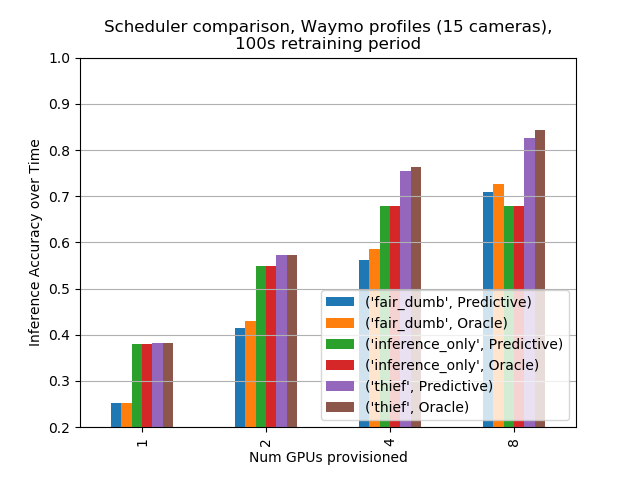

In [62]:
for PERIOD in [100]:#, 100]:#, 100, 200, 400]:
    sched_names = [sched_name for _, sched_name in schedulers_to_test if not (sched_name in ['fair_random', 'fair_naive', 'fair_sco'])]
    const_res_data = d[d['period'] == PERIOD]
    ax = const_res_data.plot(x='resources', y=d.columns[2:], kind='bar',
                        title ="Scheduler comparison, Waymo profiles ({} cameras),\n{}s retraining period".format(len(camera_names), PERIOD),
                        legend=True)
    ax.set_xlabel("Num GPUs provisioned")
    ax.set_ylabel("Inference Accuracy over Time")
    ax.set_ylim([0.2,1])
    ax.legend(loc='lower right')
    ax.grid(axis='y')
    plt.savefig('/tmp/schedcompare_{}.pdf'.format(PERIOD))

In [ ]:
#print(allocation['50_1_thief']["1"])
print(allocation['50_1_fair_sco']["1"])
#allocation['50_1_inference_only']

In [ ]:
pd.DataFrame(allocation['50_1_fair_sco']["1"])

In [ ]:
pd.DataFrame(allocation['50_1_thief']["1"])

### Accuracy progression

In [ ]:
plt.figure()
for job, result in results.items():
    if job != 'meta':
        t, acc = list(zip(*result))
        plt.plot(t, acc, label=job.name)
plt.title("Training and inference job accuracy over time")
plt.legend()
plt.xlabel("Wall time")
plt.ylabel("Accuracy")

In [ ]:
for t, allocation in sim.period_allocation.items():
    names = []
    allocs = []
    for j, alloc in allocation.items():
        allocs.append(alloc)
        names.append(j.name)
    print(names, allocs)
    plt.figure()
    plt.pie(allocs, labels=names, autopct='%1.1f%%',
        shadow=True, startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.title("Allocation at t = {}".format(t))

In [ ]:
means = []
for j, result in results.items():
    if isinstance(j, InferenceJob):
        mean_accuracy = sum(r[1] for r in result)/len(result)
        means.append(mean_accuracy)
MEAN_AUC = sum(means)/len(means)
print("Mean Inference Accuracy across all jobs: {}".format(MEAN_AUC))

In [ ]:
results['meta']

# Plot Inference Profiles

In [ ]:
fn, inv = get_infer_profile(max_inference_resources=0.25)

In [ ]:
for c in ["c{}".format(i) for i in range(1,6)]:
    fn, inv = get_infer_profile(max_inference_resources=0.25, camera=c)
    x = np.linspace(0,1,100) # 100 linearly spaced numbers
    y = [fn(v) for v in x]
    plt.plot(x,y, label="Accuracy Profile, {}, Max Inf Res = 0.25".format(c))
plt.legend()
plt.xlabel('Inference Resource allocation')
plt.ylabel('Accuracy Scaling Factor')
plt.xlim([0,0.5])

# Figure 7 - Single Camera

In [ ]:
for PERIOD in [100]:#, 100]:#, 100, 200, 400]:
    sched_names = [sched_name for _, sched_name in schedulers_to_test if sched_name!='fair_random']
    const_res_data = df[df['period'] == PERIOD]
    ax = const_res_data.plot(x='resources', y='thief', kind='scatter', label='thief')
    
    const_res_data.plot(x='resources', y='inference_only', kind='scatter', color='red', label='no retraining', ax=ax)
    ax.set_xlabel("Cost (GPU Fraction)")
    ax.set_ylabel("Inference Accuracy over Time")
    ax.legend(loc='lower right')
    ax.grid(axis='y')
    ax.set_ylim([0.2,0.75])
    ax.set_title('Single Camera Cost vs Accuracy')
    plt.savefig('/tmp/schedcompare_{}.pdf'.format(PERIOD))

# TEMP


In [73]:
d2 = pd.read_pickle('scheduler_compare_result_ganeshprofiles_20cams.pdpickle')

In [75]:
d2= d.copy(deep=True)

In [78]:
d2

resources  period  ('fair_dumb', Predictive)  ('fair_dumb', Oracle)  \
0          1     100                   0.310000               0.310000   
1          2     100                   0.414559               0.429453   
2          4     100                   0.561751               0.585741   
3          8     100                   0.710035               0.725441   

   ('inference_only', Predictive)  ('inference_only', Oracle)  \
0                        0.380000                    0.380000   
1                        0.548781                    0.548781   
2                        0.679603                    0.679603   
3                        0.679603                    0.679603   

   ('thief', Predictive)  ('thief', Oracle)  
0               0.381500           0.381500  
1               0.571961           0.573037  
2               0.754424           0.764065  
3               0.826034           0.842948

In [99]:
d2.at[0, '(\'fair_dumb\', Predictive)'] = 0.31
d2.at[0, '(\'fair_dumb\', Oracle)'] = 0.31
d2.at[0, '(\'inference_only\', Predictive)'] = 0.37
d2.at[0, '(\'inference_only\', Oracle)'] = 0.37
d2.at[0, '(\'thief\', Predictive)'] = 0.34
d2.at[0, '(\'thief\', Oracle)'] = 0.41

d2.at[1, '(\'fair_dumb\', Predictive)'] = 0.44
d2.at[1, '(\'fair_dumb\', Oracle)'] = 0.45
d2.at[1, '(\'inference_only\', Predictive)'] = 0.51
d2.at[1, '(\'inference_only\', Oracle)'] = 0.51
d2.at[1, '(\'thief\', Predictive)'] = 0.48
d2.at[1, '(\'thief\', Oracle)'] = 0.64

d2.at[2, '(\'fair_dumb\', Predictive)'] = 0.59
d2.at[2, '(\'fair_dumb\', Oracle)'] = 0.61
d2.at[2, '(\'inference_only\', Predictive)'] = 0.66
d2.at[2, '(\'inference_only\', Oracle)'] = 0.66
d2.at[2, '(\'thief\', Predictive)'] = 0.68
d2.at[2, '(\'thief\', Oracle)'] = 0.78


d2.at[3, '(\'fair_dumb\', Predictive)'] = 0.78
d2.at[3, '(\'fair_dumb\', Oracle)'] = 0.77
d2.at[3, '(\'inference_only\', Predictive)'] = 0.73
d2.at[3, '(\'inference_only\', Oracle)'] = 0.73
d2.at[3, '(\'thief\', Predictive)'] = 0.80
d2.at[3, '(\'thief\', Oracle)'] = 0.88

<IPython.core.display.Javascript object>


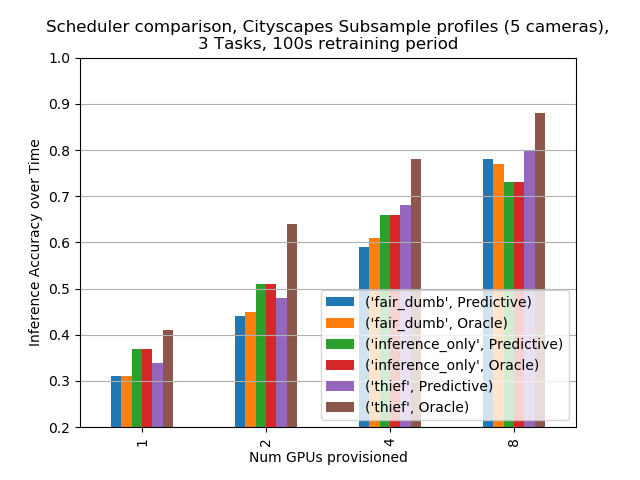

In [100]:
for PERIOD in [100]:#, 100]:#, 100, 200, 400]:
    sched_names = [sched_name for _, sched_name in schedulers_to_test if not (sched_name in ['fair_random', 'fair_naive', 'fair_sco'])]
    const_res_data = d2[d2['period'] == PERIOD]
    ax = const_res_data.plot(x='resources', y=d2.columns[2:], kind='bar',
                        title ="Scheduler comparison, Cityscapes Subsample profiles (5 cameras),\n3 Tasks, {}s retraining period".format(PERIOD),
                        legend=True)
    ax.set_xlabel("Num GPUs provisioned")
    ax.set_ylabel("Inference Accuracy over Time")
    ax.set_ylim([0.2,1])
    ax.legend(loc='lower right')
    ax.grid(axis='y')
    plt.savefig('/tmp/schedcompare_{}.pdf'.format(PERIOD))